In [1448]:
import collections
import os
import json
import logging
import string

from scipy.stats import entropy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import networkx as nx

if os.getcwd().endswith('notebook'):
    os.chdir('..')

from rna_learn.alphabet import ALPHABET_DNA, CODON_REDUNDANCY

In [2]:
sns.set(palette='colorblind', font_scale=1.3)
palette = sns.color_palette()
logging.basicConfig(level=logging.INFO, format="%(asctime)s (%(levelname)s) %(message)s")
logger = logging.getLogger(__name__)

In [3]:
db_path = os.path.join(os.getcwd(), 'data/db/seq.db')
engine = create_engine(f'sqlite+pysqlite:///{db_path}')

## Codon Bias

In [440]:
codon_to_aa_table = { 
    'ATA':'I', 'ATC':'I', 'ATT':'I', 'ATG':'M', 
    'ACA':'T', 'ACC':'T', 'ACG':'T', 'ACT':'T', 
    'AAC':'N', 'AAT':'N', 'AAA':'K', 'AAG':'K', 
    'AGC':'S', 'AGT':'S', 'AGA':'R', 'AGG':'R',                  
    'CTA':'L', 'CTC':'L', 'CTG':'L', 'CTT':'L', 
    'CCA':'P', 'CCC':'P', 'CCG':'P', 'CCT':'P', 
    'CAC':'H', 'CAT':'H', 'CAA':'Q', 'CAG':'Q', 
    'CGA':'R', 'CGC':'R', 'CGG':'R', 'CGT':'R', 
    'GTA':'V', 'GTC':'V', 'GTG':'V', 'GTT':'V', 
    'GCA':'A', 'GCC':'A', 'GCG':'A', 'GCT':'A', 
    'GAC':'D', 'GAT':'D', 'GAA':'E', 'GAG':'E', 
    'GGA':'G', 'GGC':'G', 'GGG':'G', 'GGT':'G', 
    'TCA':'S', 'TCC':'S', 'TCG':'S', 'TCT':'S', 
    'TTC':'F', 'TTT':'F', 'TTA':'L', 'TTG':'L', 
    'TAC':'Y', 'TAT':'Y', 'TAA':'*', 'TAG':'*', 
    'TGC':'C', 'TGT':'C', 'TGA':'*', 'TGG':'W', 
} 

In [4]:
possible_codons = sorted(CODON_REDUNDANCY.keys())
len(possible_codons)

64

In [118]:
codon_frequency_df = pd.read_csv(os.path.join(os.getcwd(), 'data/codon_bias.csv'))
print(len(codon_frequency_df))
codon_frequency_df.head()

3282


,assembly_accession,species_taxid,in_test_set,n_total_codons,AAA,AAC,AAG,AAT,ACA,ACC,...,TCG,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT
0,GCA_000005825.2,79885,False,1203202,50709,16004,24775,32868,27117,8825,...,6261,17452,677,2894,11946,5312,42464,14432,13363,38272
1,GCA_000005845.2,562,False,1344061,45220,28975,13763,23608,9376,31511,...,11968,11294,1244,8655,20469,6903,18597,22232,18329,29952
2,GCA_000006175.2,2188,True,511762,41277,9506,6208,28398,10533,3688,...,1693,7111,63,1841,2994,4972,27806,4525,7325,14409
3,GCA_000006605.1,38289,False,737577,4666,18501,23297,4442,3555,23745,...,7210,4657,337,4174,10432,1154,1167,18563,7493,4785
4,GCA_000006685.1,83560,False,323926,13771,3527,5541,8332,5378,2884,...,1987,11321,136,1924,3143,3316,11026,5157,6629,10685


In [1668]:
len(codon_frequency_df['species_taxid'].unique())

2680

In [1671]:
len(codon_frequency_df)

3282

## Load temperatures

In [970]:
temperature_query = """
select s.assembly_accession, t.species_taxid, t.growth_tmp from assembly_source as s
left join (
    select species_taxid, growth_tmp from species_traits
) as t
on s.species_taxid = t.species_taxid
"""
temperatures_df = pd.read_sql(temperature_query, engine)
temperatures_df.head()

,assembly_accession,species_taxid,growth_tmp
0,GCA_000005825.2,79885,31.000
1,GCA_000005845.2,562,37.875
2,GCA_000006175.2,2188,36.600
3,GCA_000006605.1,38289,37.000
4,GCA_000006685.1,83560,37.000


In [976]:
species_temperatures_df = temperatures_df[
    ['species_taxid', 'growth_tmp']].groupby('species_taxid').first().reset_index()

## Join temperature

In [120]:
codon_df = pd.merge(
    codon_frequency_df,
    temperatures_df,
    how='left',
    on='assembly_accession'
)
len(codon_df)

3282

In [121]:
codon_df.head()

,assembly_accession,species_taxid,in_test_set,n_total_codons,AAA,AAC,AAG,AAT,ACA,ACC,...,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT,growth_tmp
0,GCA_000005825.2,79885,False,1203202,50709,16004,24775,32868,27117,8825,...,17452,677,2894,11946,5312,42464,14432,13363,38272,31.000
1,GCA_000005845.2,562,False,1344061,45220,28975,13763,23608,9376,31511,...,11294,1244,8655,20469,6903,18597,22232,18329,29952,37.875
2,GCA_000006175.2,2188,True,511762,41277,9506,6208,28398,10533,3688,...,7111,63,1841,2994,4972,27806,4525,7325,14409,36.600
3,GCA_000006605.1,38289,False,737577,4666,18501,23297,4442,3555,23745,...,4657,337,4174,10432,1154,1167,18563,7493,4785,37.000
4,GCA_000006685.1,83560,False,323926,13771,3527,5541,8332,5378,2884,...,11321,136,1924,3143,3316,11026,5157,6629,10685,37.000


## Codon ratio model

In [125]:
def compute_codon_ratio(codon_df):
    processed_codons = set()
    for codon in sorted(CODON_REDUNDANCY.keys()):
        if codon in processed_codons:
            continue
        elif len(CODON_REDUNDANCY[codon]) <= 1:
            processed_codons.add(codon)
            continue
        
        synonymous_codons = CODON_REDUNDANCY[codon]
        for c, _ in synonymous_codons:
            processed_codons.add(c)
            codon_df[f'{c}_ratio'] = codon_df[c] / sum((codon_df[cod] for cod, _ in synonymous_codons))

In [126]:
compute_codon_ratio(codon_df)

In [131]:
ratio_columns = [c for c in codon_df.columns if c.endswith('_ratio')]

x_train = codon_df[~codon_df['in_test_set']][ratio_columns].values
y_train = codon_df[~codon_df['in_test_set']]['growth_tmp'].values

x_test = codon_df[codon_df['in_test_set']][ratio_columns].values
y_test = codon_df[codon_df['in_test_set']]['growth_tmp'].values

print(len(x_train), len(x_test))

2222 1060


In [139]:
def fit_linear_regression(y_actual, x):
    X = sm.add_constant(x)
    model = sm.OLS(y_actual, X)
    results = model.fit()
    y_fit = results.predict(X)
    return results, y_fit

In [140]:
results, y_fit_train = fit_linear_regression(y_train, x_train)

In [1664]:
def plot_true_vs_prediction_per_specie(y_true, y_pred, ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(8, 8))
    
    palette = sns.color_palette()
    
    x_straight = range(int(np.min(y_true)) - 1, int(np.max(y_true)) + 1)
    ax.plot(x_straight, x_straight, '--', color=palette[1], linewidth=2)
    
    ax.scatter(y_true, y_pred, color=palette[0], alpha=0.5, label='Species')
    
    ax.set_xlabel('Temperature °C (truth)')
    ax.set_ylabel('Temperature °C (prediction)')
    return ax


def compute_and_plot_pattern_against_ogt(y_actual, x, results, ax=None):
    palette = sns.color_palette()

    X = sm.add_constant(x)
    y_fit = results.predict(X)
    
    std, upper, lower = wls_prediction_std(results)
    
    ax = plot_true_vs_prediction_per_specie(y_actual, y_fit, ax=ax)
    
    df_data = [
        [y_actual[i], y_fit[i], std[i]]
        for i in range(len(y_actual))
    ]
    df = pd.DataFrame(df_data, columns=['growth_tmp_actual', 'growth_tmp_prediction', 'growth_tmp_std'])
    
    pred_mean = df[['growth_tmp_actual', 'growth_tmp_prediction']].groupby('growth_tmp_actual').mean()
    std_mean = df[['growth_tmp_actual', 'growth_tmp_std']].groupby('growth_tmp_actual').mean().reset_index()
    x_fill = std_mean['growth_tmp_actual'].values
    x_base = pred_mean['growth_tmp_prediction'].values
    y_fill_1 = x_base - 2 * std_mean['growth_tmp_std'].values
    y_fill_2 = x_base + 2 * std_mean['growth_tmp_std'].values
    ax.fill_between(x_fill, y_fill_1, y_fill_2, alpha=0.2, color=palette[1], label='Uncertainty');

    ax.legend(loc='upper left')
    
    return ax, y_fit


def compute_mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

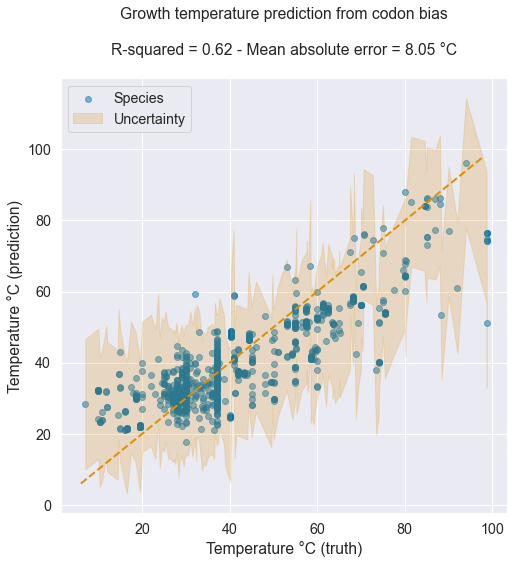

In [1665]:
ax, y_fit_test = compute_and_plot_pattern_against_ogt(y_test, x_test, results)
ax.set_title((
    f'Growth temperature prediction from codon bias\n\n'
    f'R-squared = {results.rsquared:.2f} - Mean absolute error = {compute_mae(y_test, y_fit_test):.2f} °C\n'
));

In [1658]:
def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

In [172]:
mae(y_train, y_fit_train)

6.712866857458104

In [173]:
mae(y_test, y_fit_test)

8.045457980527855

## Phylogeny

In [385]:
phylogeny_query = """
select species_taxid, species, genus, family, "order", class, phylum, superkingdom
from species_traits
where species_taxid in (
    select species_taxid from train_test_split
    where in_test_set = 1
)
"""
phylogeny_df = pd.read_sql(phylogeny_query, engine)
phylogeny_df.head()

,species_taxid,species,genus,family,order,class,phylum,superkingdom
0,7,Azorhizobium caulinodans,Azorhizobium,Xanthobacteraceae,Rhizobiales,Alphaproteobacteria,Proteobacteria,Bacteria
1,11,Cellulomonas gilvus,Cellulomonas,Cellulomonadaceae,Micrococcales,Actinobacteria,Actinobacteria,Bacteria
2,14,Dictyoglomus thermophilum,Dictyoglomus,Dictyoglomaceae,Dictyoglomales,Dictyoglomia,Dictyoglomi,Bacteria
3,19,Pelobacter carbinolicus,Pelobacter,Desulfuromonadaceae,Desulfuromonadales,Deltaproteobacteria,Proteobacteria,Bacteria
4,24,Shewanella putrefaciens,Shewanella,Shewanellaceae,Alteromonadales,Gammaproteobacteria,Proteobacteria,Bacteria


In [160]:
phylogeny_df[['superkingdom', 'species_taxid']].groupby('superkingdom').count()

,species_taxid
superkingdom,
Archaea,45
Bacteria,525


In [161]:
phylogeny_df[['superkingdom', 'phylum', 'species_taxid']].groupby(['superkingdom', 'phylum']).count()

species_taxid
superkingdom phylum                            
Archaea      Crenarchaeota                   13
             Euryarchaeota                   32
Bacteria     Acidobacteria                    1
             Actinobacteria                  77
             Aquificae                        4
             Bacteroidetes                   26
             Calditrichaeota                  1
             Chlamydiae                       2
             Chlorobi                         1
             Chloroflexi                      5
             Cyanobacteria                    2
             Deinococcus-Thermus              7
             Dictyoglomi                      1
             Firmicutes                     146
             Fusobacteria                     1
             Gemmatimonadetes                 1
             Nitrospirae                      1
             Planctomycetes                   1
             Proteobacteria                 215
             Spirochaetes                     4
             Synergistetes                    2
             Tenericutes                     18
             Thermotogae                      9

In [162]:
phylogeny_df[[
    'superkingdom', 
    'phylum', 
    'class', 
    'species_taxid',
]].groupby([
    'superkingdom', 
    'phylum', 
    'class',
]).count()

species_taxid
superkingdom phylum              class                               
Archaea      Crenarchaeota       Thermoprotei                      13
             Euryarchaeota       Archaeoglobi                       2
                                 Halobacteria                      11
                                 Methanococci                       2
                                 Methanomicrobia                    5
                                 Methanopyri                        1
                                 Thermococci                       10
                                 Thermoplasmata                     1
Bacteria     Acidobacteria       Acidobacteriia                     1
             Actinobacteria      Actinobacteria                    75
                                 Rubrobacteria                      2
             Aquificae           Aquificae                          4
             Bacteroidetes       Bacteroidia                        7
                                 Chitinophagia                      2
                                 Cytophagia                         3
                                 Flavobacteriia                    12
                                 Sphingobacteriia                   1
             Calditrichaeota     Calditrichae                       1
             Chlamydiae          Chlamydiia                         2
             Chlorobi            Chlorobia                          1
             Chloroflexi         Anaerolineae                       3
                                 Chloroflexia                       1
                                 Thermomicrobia                     1
             Deinococcus-Thermus Deinococci                         7
             Dictyoglomi         Dictyoglomia                       1
             Firmicutes          Bacilli                           94
                                 Clostridia                        47
                                 Negativicutes                      3
                                 Tissierellia                       2
             Fusobacteria        Fusobacteriia                      1
             Gemmatimonadetes    Gemmatimonadetes                   1
             Nitrospirae         Nitrospira                         1
             Planctomycetes      Planctomycetia                     1
             Proteobacteria      Acidithiobacillia                  1
                                 Alphaproteobacteria               46
                                 Betaproteobacteria                36
                                 Deltaproteobacteria               20
                                 Epsilonproteobacteria             12
                                 Gammaproteobacteria               98
                                 Oligoflexia                        2
             Spirochaetes        Spirochaetia                       4
             Synergistetes       Synergistia                        2
             Tenericutes         Mollicutes                        18
             Thermotogae         Thermotogae                        9

In [386]:
codon_with_phylogeny_df = pd.merge(
    codon_df,
    phylogeny_df,
    how='left',
    on='species_taxid',
)
print(len(codon_with_phylogeny_df))

3282


In [166]:
codon_test = codon_with_phylogeny_df[codon_with_phylogeny_df['in_test_set']].reset_index(drop=True)

In [164]:
def plot_true_vs_prediction_per_segment(df, y_true, y_pred, segmentation_column, n_items_threshold=3):
    threshold = 5
    possible_values = [
        v for v in df[segmentation_column].unique()
        if len(df[df[segmentation_column] == v].index) > n_items_threshold
    ]
    n_cols = 2
    n_rows = int(np.ceil(len(possible_values) / n_cols))
    _, axes = plt.subplots(n_rows, 2, figsize=(8 * n_cols, 8 * n_rows))
    axes = axes.flatten()
    
    palette = sns.color_palette()
    
    x_straight = range(int(np.min(y_true)) - 1, int(np.max(y_true)) + 1)
    for i in range(len(axes)):
        ax = axes[i]
        
        if (i + 1) > len(possible_values):
            ax.remove()
            continue
        
        possible_value = possible_values[i]
        
        ix = df[df[segmentation_column] == possible_value].index
        if len(ix) > n_items_threshold:
            ax.plot(x_straight, x_straight, '--', color=palette[1], linewidth=2)
            ax.scatter(y_true[ix], y_pred[ix], alpha=0.5, label=possible_value)
            ax.set_title(possible_value)

            ax.set_xlabel('Temperature °C (truth)')
            ax.set_ylabel('Temperature °C (prediction)')

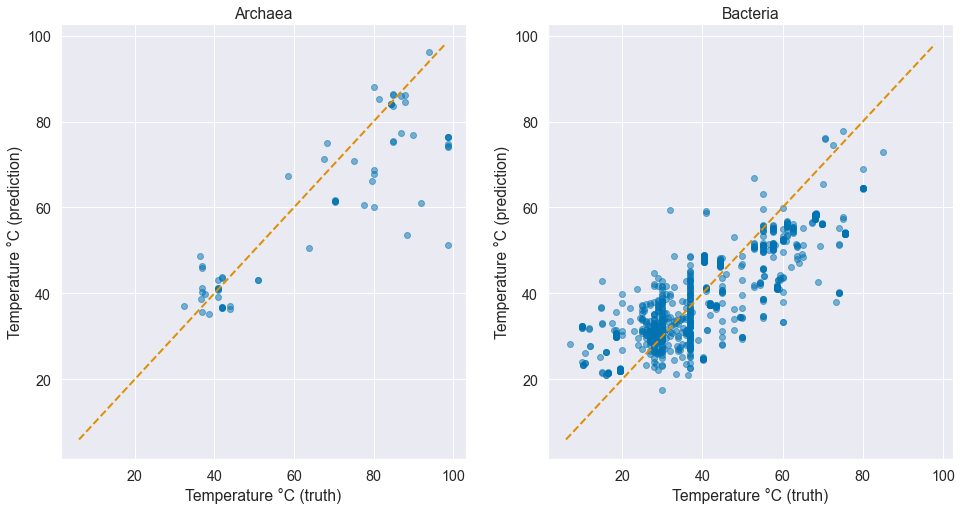

In [167]:
plot_true_vs_prediction_per_segment(
    codon_test, 
    y_test, 
    y_fit_test,
    segmentation_column='superkingdom',
)

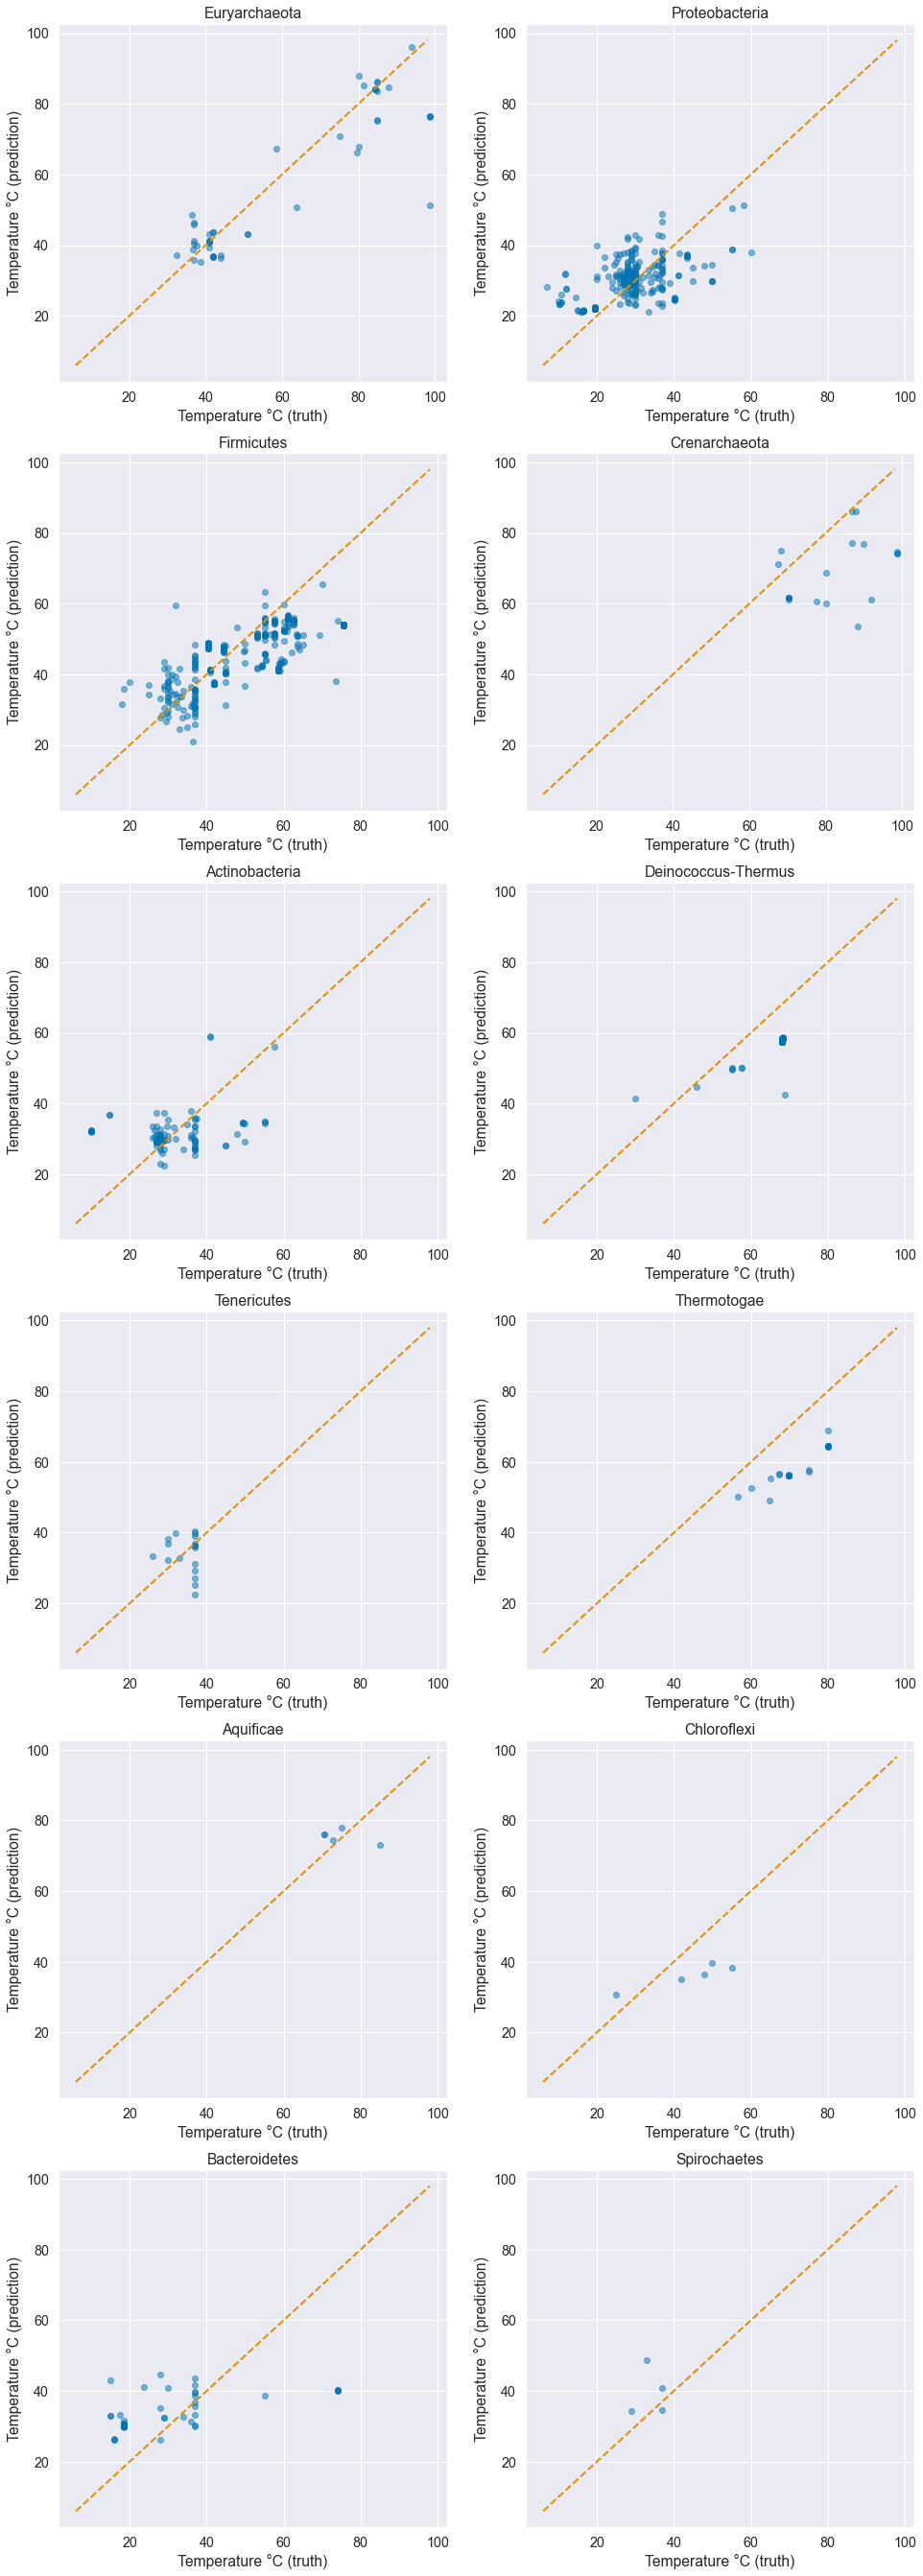

In [169]:
plot_true_vs_prediction_per_segment(
    codon_test, 
    y_test, 
    y_fit_test,
    segmentation_column='phylum',
)

In [176]:
results.params

array([  5.458943  ,   3.56613788,   1.89280513,  -7.77649539,
        13.23543839,  -4.48495806,  -8.33884914,   4.19664132,
        14.08610888, -16.34178529,  19.64366688, -52.4344612 ,
         9.50061777,  -7.53049763,  52.62140248,   5.02500039,
        11.96172608, -25.60271295,  16.62765253, -52.09826697,
        49.54554392,  10.38126011, -25.16539965,  20.24308254,
         5.36971817,   0.08922483,   8.26007106,  -2.80112805,
       -27.13179652,  -5.08726006,  19.44018735,  18.23781223,
        14.8761475 ,  -6.28605849, -20.38055256, -17.2483225 ,
        17.89322537,  16.60450367,  -0.35260828,   5.81155129,
         3.27831769,   2.18062532,  36.36793316,   3.72197605,
        -5.86752807, -28.76343814,   8.63712107, -29.17868158,
         5.43905798,  20.56144553,  -8.70042447,   3.93264387,
       -11.37909354,  21.60581715,  -8.55754133,   4.7555653 ,
         9.26091904,  -3.05072275,   8.50966575, -12.96993379,
        18.42887679,   6.84304768,  -1.38410467])

In [187]:
feature_importance = np.abs(results.params[1:] / results.bse[1:])

In [189]:
feature_importance

array([ 2.10214631,  1.12424697,  2.6831855 ,  4.59094671,  0.88468653,
        2.14286898,  1.02893047,  3.40800832,  3.74120518,  5.05321843,
        8.21709624,  2.41649738,  2.5678636 , 14.77510659,  0.81312307,
        2.47547639,  4.04069409,  3.02230881,  6.70428408,  8.89263781,
        4.01927352,  9.34370562,  7.86198486,  2.9963364 ,  0.04965069,
        3.57916173,  1.21616973,  5.6501089 ,  1.25242067,  5.71847886,
        5.93631885,  3.15133425,  1.42807991,  2.60706082,  4.58418159,
        4.92803329,  4.40031427,  0.22455535,  3.72856248,  1.3218534 ,
        0.86651521,  6.54727092,  0.78451273,  1.26013672,  6.06032928,
        1.96159608,  7.03308547,  1.5169691 ,  4.33069267,  2.16770285,
        1.03253919,  2.67752474,  6.75281935,  3.43189676,  1.93476195,
        6.37077613,  1.31184561,  3.64011414,  6.06731715,  8.7139013 ,
        3.74224568,  0.76020899])

In [206]:
feature_importance[20:23]

array([4.01927352, 9.34370562, 7.86198486])

In [205]:
ratio_columns[20:23]

['ATT_ratio', 'ATC_ratio', 'ATA_ratio']

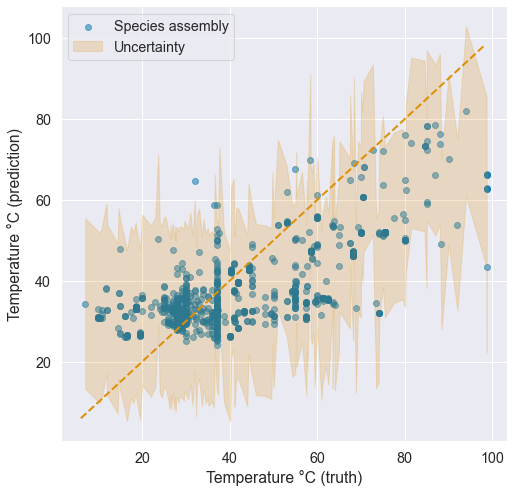

In [208]:
cols = [
    'AGA_ratio', 
    'AGG_ratio', 
    'CGT_ratio', 
    'CGC_ratio', 
    'CGA_ratio', 
    'CGG_ratio',
    'ATT_ratio', 
    'ATC_ratio', 
    'ATA_ratio',
]
res, f = fit_linear_regression(
    y_actual=y_train,
    x=codon_df[~codon_df['in_test_set']][cols].values
)
compute_and_plot_pattern_against_ogt(
    y_test, 
    codon_df[codon_df['in_test_set']][cols].values, 
    res
);

In [441]:
def amino_acid_importance(y, x, results, possible_codons, ratio_columns):
    aa_importance = {}
    
    weights_importance = np.abs(results.params[1:] / results.bse[1:])
    weights_importance_dict = {
        ratio_columns[i].replace('_ratio', ''): weights_importance[i]
        for i in range(len(weights_importance))
    }
    
    processed_codons = set()
    for codon in possible_codons:
        if len(CODON_REDUNDANCY[codon]) <= 1:
            continue
        elif codon in processed_codons:
            continue
            
        importance_factors = []
        for c, _ in CODON_REDUNDANCY[codon]:
            if c in processed_codons:
                continue
                
            processed_codons.add(c)
            
            importance_factors.append(
                weights_importance_dict[c]
            )
            
        aa = codon_to_aa_table[codon]
            
        aa_importance[aa] = np.mean(importance_factors)
    
    return aa_importance

In [442]:
aa_importance = amino_acid_importance(y_test, x_test, results, possible_codons, ratio_columns)

In [444]:
sorted([(k, v) for k, v in aa_importance.items()], key=lambda t: t[1], reverse=True)

[('C', 7.390609225741814),
 ('I', 7.074987997573898),
 ('R', 6.128497902148081),
 ('P', 4.639331818976233),
 ('S', 4.324754041065607),
 ('*', 3.9124782796655353),
 ('G', 3.7105858281695188),
 ('A', 3.6630624105820284),
 ('N', 3.637066104298797),
 ('L', 3.5165006870361193),
 ('V', 3.1576465337559703),
 ('Y', 2.4759798750799895),
 ('H', 2.3976657325528703),
 ('F', 2.2512273396487776),
 ('E', 1.976558913808437),
 ('T', 1.8661235754655932),
 ('K', 1.6131966375738807),
 ('Q', 1.5229935480855108),
 ('D', 1.0941843033942251)]

In [221]:
q = """
select assembly_accession, species_taxid, organism_name
from assembly_source 
where organism_name like '%Methanosarcina barkeri%'
"""
pd.read_sql(q, engine)

,assembly_accession,species_taxid,organism_name
0,GCA_000970025.1,2208,Methanosarcina barkeri MS


In [227]:
codon_df[codon_df['assembly_accession'] == 'GCA_000970025.1'][['TAG_ratio', 'growth_tmp']]

,TAG_ratio,growth_tmp
1324,0.045273,37.633


In [228]:
codon_df.iloc[0][['TAG_ratio', 'growth_tmp']]

TAG_ratio     0.181084
growth_tmp          31
Name: 0, dtype: object

In [235]:
codon_df.sort_values(['TAG_ratio']).head(30)[[
    'assembly_accession', 
    'species_taxid', 
    'growth_tmp', 
    'TAG_ratio',
    'TAA_ratio',
    'TGA_ratio',
]]

,assembly_accession,species_taxid,growth_tmp,TAG_ratio,TAA_ratio,TGA_ratio
1795,GCA_001889405.1,2177,30.000,0.010585,0.489415,0.500000
705,GCA_000196655.1,2322,50.000,0.010686,0.677649,0.311665
1329,GCA_000970325.1,2226,31.400,0.011374,0.433576,0.555050
438,GCA_000025865.1,2176,37.000,0.011575,0.478108,0.510317
170,GCA_000013725.1,29291,22.167,0.020696,0.451783,0.527521
298,GCA_000019905.1,332410,29.000,0.033167,0.584743,0.382090
1327,GCA_000970265.1,170861,24.100,0.035148,0.502333,0.462519
1323,GCA_000969925.1,2210,51.000,0.037416,0.545490,0.417093
357,GCA_000023205.1,1270,29.000,0.037567,0.019678,0.942755
1321,GCA_000969885.1,2210,51.000,0.037588,0.553641,0.408771


In [236]:
q = """
select assembly_accession, species_taxid, organism_name
from assembly_source 
where species_taxid = 2177
"""
pd.read_sql(q, engine)

,assembly_accession,species_taxid,organism_name
0,GCA_001889405.1,2177,Methanohalophilus halophilus


In [242]:
codon_df[codon_df['TGA'] > 0].sort_values(['TGA_ratio'])[[
    'assembly_accession', 
    'species_taxid', 
    'growth_tmp', 
    'TAG_ratio',
    'TAA_ratio',
    'TGA_ratio',
]]

,assembly_accession,species_taxid,growth_tmp,TAG_ratio,TAA_ratio,TGA_ratio
2868,GCA_009730295.1,84135,37.000,0.211838,0.769470,0.018692
2744,GCA_008151785.1,89152,37.000,0.237606,0.741402,0.020992
2225,GCA_003181555.1,1502,40.333,0.217361,0.753705,0.028934
2533,GCA_004329605.1,1502,40.333,0.217566,0.751458,0.030977
2239,GCA_003181895.1,1502,40.333,0.216109,0.752607,0.031284
...,...,...,...,...,...,...
732,GCA_000212695.1,1708,31.000,0.057682,0.007443,0.934875
357,GCA_000023205.1,1270,29.000,0.037567,0.019678,0.942755
1444,GCA_001275345.1,71999,29.000,0.039391,0.016115,0.944494
2284,GCA_003355475.1,556288,28.000,0.045198,0.009102,0.945700


In [560]:
test_set_df = codon_with_phylogeny_df[codon_with_phylogeny_df['in_test_set']].reset_index(drop=True)

## Are ratios similar across thermophiles / mesophiles / psychrophiles?

In [243]:
from sklearn.manifold import TSNE

In [316]:
def plot_embedding(x_embedded, colors, cmap='YlOrRd', cbar=True):
    _, ax = plt.subplots(1, 1, figsize=(12, 6))
    
    x = x_embedded[:,0]
    y = x_embedded[:,1]
    
    sc = ax.scatter(x, y, c=colors, cmap=cmap, alpha=0.5)
    
    if cbar:
        plt.colorbar(sc)
    
    return ax

In [317]:
x_test_embedded = TSNE(n_components=2, perplexity=40).fit_transform(x_test)
x_test_embedded.shape

(1060, 2)

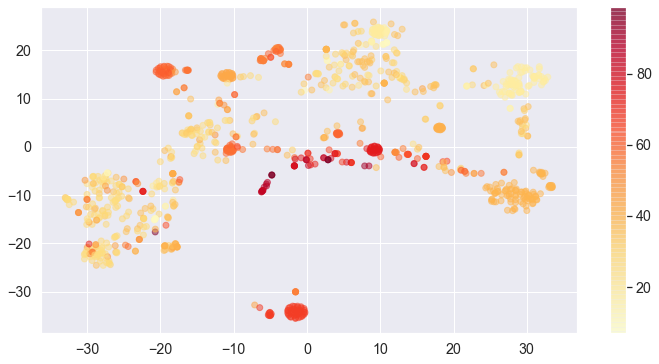

In [345]:
ax = plot_embedding(x_test_embedded, y_test);
xlim = ax.get_xlim()
ylim = ax.get_ylim()

In [609]:
def plot_embedding_per_column(x_embedded, input_df, column, temperature_range=None, min_elements=1):
    _, ax = plt.subplots(1, 1, figsize=(12, 6))
    
    df = input_df
    if temperature_range is not None:
        df = input_df[
            input_df['growth_tmp'].between(*temperature_range)
        ]
        
    df = df.drop_duplicates(['species_taxid'])
    
    categories = df[df[column].notnull()][column].unique()
    
    for cat in sorted(categories):
        ix = df[df[column] == cat].index
        
        if len(ix) < min_elements:
            continue
            
        x = x_embedded[ix, 0]
        y = x_embedded[ix, 1]
        
        ax.scatter(x, y, alpha=.8, label=cat)
    
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    
    return ax

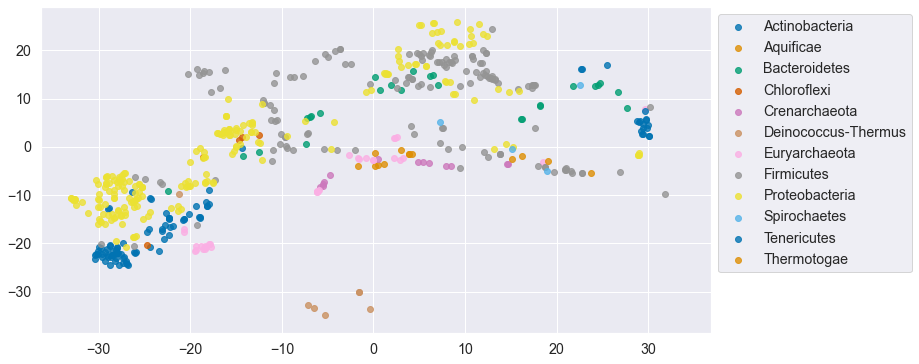

In [610]:
ax = plot_embedding_per_column(
    x_test_embedded, 
    test_set_df,
    column='phylum',
    min_elements=3,
)
ax.set_xlim(xlim);
ax.set_ylim(ylim);

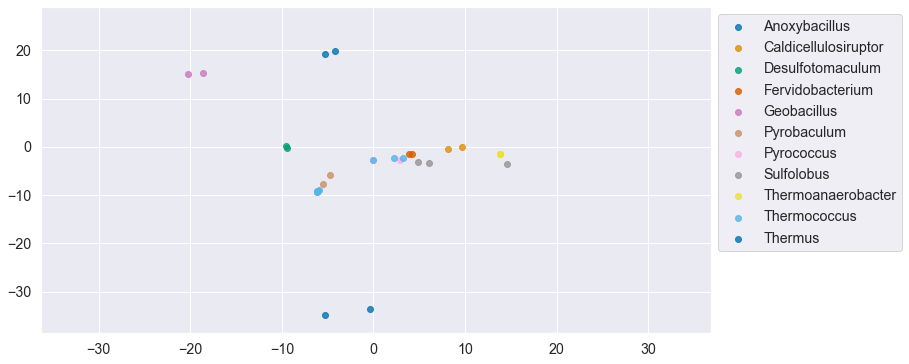

In [612]:
ax = plot_embedding_per_column(
    x_test_embedded, 
    test_set_df,
    column='genus',
    temperature_range=(60, 120),
    min_elements=2,
)
ax.set_xlim(xlim);
ax.set_ylim(ylim);

## Heatmap

In [584]:
def make_heatmap_data_raw(df, ratio_columns, grouping_column, temperature_range=None):
    if temperature_range is None:
        agg_df = df[
            [grouping_column] + ratio_columns
        ].groupby(grouping_column).mean().reset_index()
    else:
        agg_df = df[df['growth_tmp'].between(*temperature_range)][
            [grouping_column] + ratio_columns
        ].groupby(grouping_column).mean().reset_index()
    
    data = []
    for tpl in agg_df.itertuples():
        grouping_column_val = getattr(tpl, grouping_column)
        for col in ratio_columns:
            codon = col.replace('_ratio', '')
            row = [
                grouping_column_val,
                codon_to_aa_table[codon],
                codon,
                getattr(tpl, col),
            ]
            data.append(row)
        
    output_columns = [
        grouping_column,
        'aa',
        'codon',
        'codon_ratio',
    ]
    return pd.DataFrame(data, columns=output_columns)

In [706]:
def make_heatmap(
    df, 
    ratio_columns, 
    grouping_column, 
    temperature_range, 
    amino_acids=None, 
    ax=None, 
    figsize=None,
    sort_master=None,
):
    heatmap_df_raw = make_heatmap_data_raw(df, ratio_columns, grouping_column, temperature_range)
    
    if amino_acids is not None:
        heatmap_df_raw = heatmap_df_raw[heatmap_df_raw['aa'].isin(amino_acids)].reset_index(drop=True)
    
    heatmap_df = heatmap_df_raw.pivot(['aa', 'codon'], grouping_column, 'codon_ratio')
    
    if sort_master is not None:
        columns = sorted(
            heatmap_df.columns.tolist(),
            key=lambda s: sort_master.index(s),
        )
        heatmap_df.columns = columns
    
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=figsize or (25, 20))
        
    sns.heatmap(heatmap_df, ax=ax, cmap='Greys')
    
    return ax, heatmap_df

In [707]:
sorted([(k, v) for k, v in aa_importance.items()], key=lambda t: t[1], reverse=True)

[('C', 7.390609225741814),
 ('I', 7.074987997573898),
 ('R', 6.128497902148081),
 ('P', 4.639331818976233),
 ('S', 4.324754041065607),
 ('*', 3.9124782796655353),
 ('G', 3.7105858281695188),
 ('A', 3.6630624105820284),
 ('N', 3.637066104298797),
 ('L', 3.5165006870361193),
 ('V', 3.1576465337559703),
 ('Y', 2.4759798750799895),
 ('H', 2.3976657325528703),
 ('F', 2.2512273396487776),
 ('E', 1.976558913808437),
 ('T', 1.8661235754655932),
 ('K', 1.6131966375738807),
 ('Q', 1.5229935480855108),
 ('D', 1.0941843033942251)]

In [1231]:
def vertical_lines_sep(ax, heatmap_df, dict_map, color, alpha=0.5):
    prev = None
    for i, species in enumerate(heatmap_df.columns):
        v = dict_map[species]
        if prev is not None and prev != v:
            ax.axvline(i, color=color, alpha=alpha);
            prev = v
        else:
            prev = v

In [728]:
bacteria_species = set(test_set_df[test_set_df['superkingdom'] == 'Bacteria']['species'].unique())
species_to_phylum = {
    species: phylum
    for phylum, species in test_set_df[['phylum', 'species']].values
}

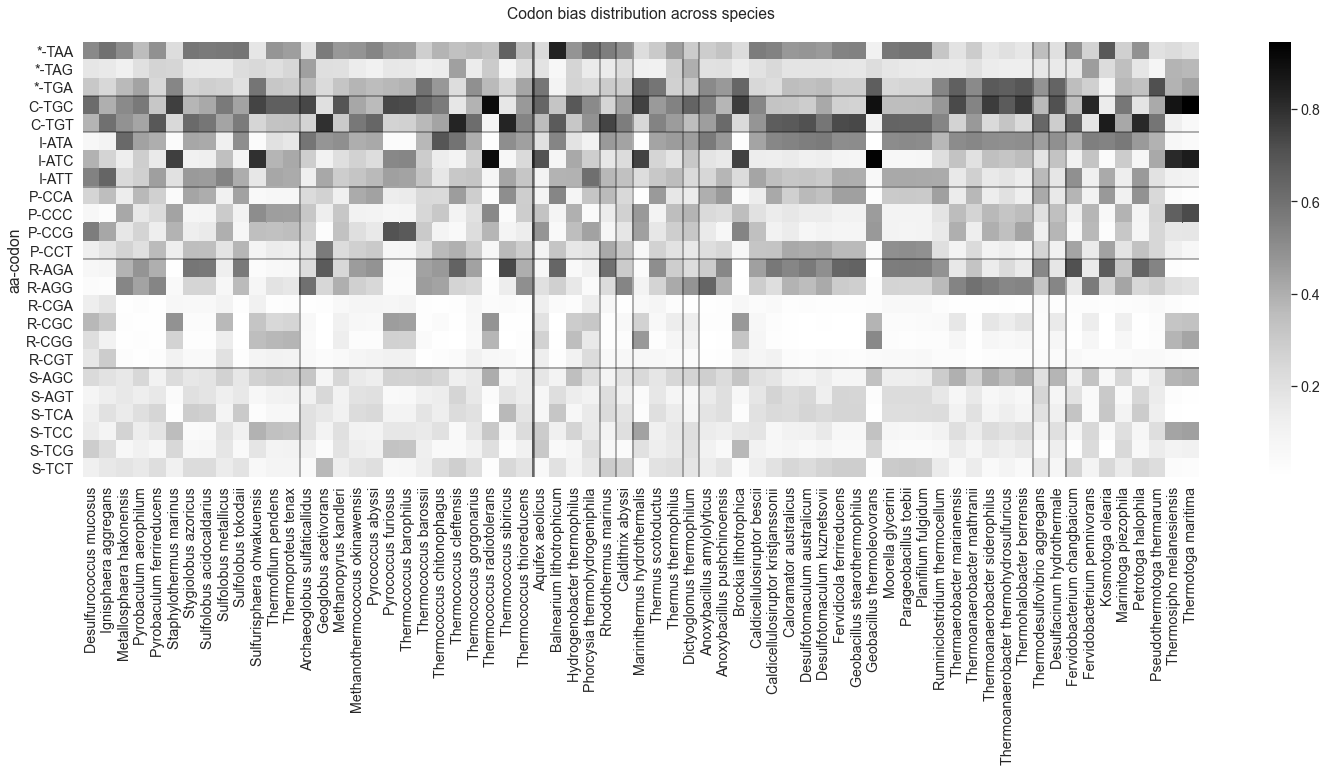

In [1709]:
species_sort = [
    t[-1]
    for t in test_set_df[
        ['superkingdom', 'phylum', 'genus', 'species', 'AAA', 'CCC', 'GGG']
    ].groupby(['superkingdom', 'phylum','genus', 'species']).mean().index.tolist()
]
ax, heatmap_df = make_heatmap(
    test_set_df, 
    ratio_columns, 
    grouping_column='species',
    temperature_range=(60, 120),
    amino_acids=['C', 'I', 'R', 'P', 'S', '*'],
    sort_master=species_sort,
    figsize=(25, 8),
)

prev_aa = None
for i, (aa, codon) in enumerate(heatmap_df.index.tolist()):
    if prev_aa is not None and aa != prev_aa:
        ax.axhline(i, color='black', alpha=0.4);
        prev_aa = aa
    else:
        prev_aa = aa
        
vertical_lines_sep(ax, heatmap_df, species_to_phylum, color='black', alpha=0.4);

for i, species in enumerate(heatmap_df.columns):
    if species in bacteria_species:
        ax.axvline(i, color='black', alpha=0.4, linewidth=3);
        break
        
ax.set_title('Codon bias distribution across species\n');

## Compute distance between species

In [1379]:
def kl_divergence(p, q, axis=0):
    return entropy(p, q, axis=axis)


def jensen_shannon_divergence(p, q, axis=0):
    m = (1/2) * (p + q)
    return (
        (1/2) * kl_divergence(p, m, axis) + 
        (1/2) * kl_divergence(q, m, axis)
    )

In [888]:
def distance_between_species(df, species_1, species_2, weights_dict=None):
    agg_df = df[df['species'].isin([
        species_1, 
        species_2,
    ])][['species_taxid', 'species'] + ratio_columns].groupby(['species_taxid', 'species']).mean()
    
    measures = []
    weights = []
    
    seen_codons = set()
    for c in possible_codons:
        if c in seen_codons:
            continue
    
        redundant_codons = [cod for cod, _ in CODON_REDUNDANCY[c]]
        if len(redundant_codons) < 2:
            seen_codons.add(c)
            continue
            
        aa = codon_to_aa_table[c]
        
        p = np.zeros((len(redundant_codons),))
        q = np.zeros((len(redundant_codons),))
        for i, codon in enumerate(redundant_codons):
            seen_codons.add(codon)
            pi, qi = agg_df[f'{codon}_ratio'].values
            p[i] = pi
            q[i] = qi
        
        if weights_dict is not None:
            weights.append(weights_dict[aa])
            
        measures.append(
            jensen_shannon_divergence(p, q)
        )
        
    if weights_dict is None:
        return np.mean(measures)
    else:
        weights = np.array(weights) / np.sum(weights)
        return np.average(measures, weights=weights)

In [889]:
distance_between_species(test_set_df, 'Thermococcus radiotolerans', 'Thermotoga maritima')

0.04378984069228989

In [890]:
distance_between_species(test_set_df, 'Thermosipho melanesiensis', 'Thermotoga maritima')

0.07751900953905895

In [891]:
distance_between_species(test_set_df, 'Azorhizobium caulinodans', 'Thermococcus radiotolerans')

0.054759904766251886

In [892]:
distance_between_species(test_set_df, 'Thermococcus radiotolerans', 'Desulfurococcus mucosus')

0.02250581778325244

In [897]:
test_set_df[test_set_df['species'].isin([
    'Thermococcus radiotolerans', 'Thermotoga maritima', 'Desulfurococcus mucosus', 'Thermosipho melanesiensis'
])][['species_taxid', 'species', 'growth_tmp']].drop_duplicates()

,species_taxid,species,growth_tmp
16,2336,Thermotoga maritima,80.00
56,46541,Thermosipho melanesiensis,69.95
147,2275,Desulfurococcus mucosus,87.00
538,187880,Thermococcus radiotolerans,88.00


## Distance matrix

In [1044]:
species_codon_ratios_path = os.path.join(os.getcwd(), 'data/species_codon_ratios.csv')

q = 'select species_taxid, species, genus, family, "order", class, phylum, superkingdom from species_traits'

species_codon_df = pd.merge(
    pd.read_csv(species_codon_ratios_path),
    species_temperatures_df,
    how='inner',
    on='species_taxid',
)
species_codon_df = pd.merge(
    species_codon_df,
    pd.read_sql(q, engine),
    how='inner',
    on='species_taxid',
)
species_codon_df.head()

,species_taxid,in_test_set,AAA_ratio,AAG_ratio,AAT_ratio,AAC_ratio,ACT_ratio,ACC_ratio,ACA_ratio,ACG_ratio,...,TTC_ratio,TTT_ratio,growth_tmp,species,genus,family,order,class,phylum,superkingdom
0,7,True,0.082550,0.917450,0.327724,0.672276,0.024511,0.575353,0.036262,0.363875,...,0.897180,0.102820,30.00,Azorhizobium caulinodans,Azorhizobium,Xanthobacteraceae,Rhizobiales,Alphaproteobacteria,Proteobacteria,Bacteria
1,9,False,0.919627,0.080373,0.858168,0.141832,0.454569,0.050026,0.446018,0.049387,...,0.080224,0.919776,24.00,Buchnera aphidicola,Buchnera,Erwiniaceae,Enterobacterales,Gammaproteobacteria,Proteobacteria,Bacteria
2,11,True,0.007302,0.992698,0.010730,0.989270,0.008586,0.425527,0.015789,0.550098,...,0.994594,0.005406,26.00,Cellulomonas gilvus,Cellulomonas,Cellulomonadaceae,Micrococcales,Actinobacteria,Actinobacteria,Bacteria
3,14,True,0.664866,0.335134,0.775571,0.224429,0.458203,0.188052,0.304183,0.049563,...,0.189441,0.810559,74.15,Dictyoglomus thermophilum,Dictyoglomus,Dictyoglomaceae,Dictyoglomales,Dictyoglomia,Dictyoglomi,Bacteria
4,19,True,0.551810,0.448190,0.440559,0.559441,0.099134,0.591478,0.097796,0.211592,...,0.502549,0.497451,30.00,Pelobacter carbinolicus,Pelobacter,Desulfuromonadaceae,Desulfuromonadales,Deltaproteobacteria,Proteobacteria,Bacteria


In [1589]:
distance_matrix_path = os.path.join(os.getcwd(), 'data/distance_matrix.npy')
distance_matrix = np.load(distance_matrix_path, allow_pickle=True)
distance_matrix.shape

(2680, 2680)

In [1595]:
ix = species_codon_df[species_codon_df['species_taxid'].isin((2336, 187880))].index
ix[0], ix[-1], distance_matrix[ix[0], ix[-1]], distance_matrix[ix[-1], ix[0]]

(682, 1769, 0.1956751534857982, 0.1956751534857982)

In [1596]:
def compute_appropriate_threshold_distance(species_codon_df, distance_matrix):    
    output_columns = [
        'species_taxid',
        'n_neighbours',
        'distance_mean',
        'distance_std',
        'distance_min',
        'distance_max',
    ]
    
    data = []
    for ix in range(len(species_codon_df)):
        species = species_codon_df.loc[ix]

        d = [
            v for i, v in enumerate(distance_matrix[ix])
            if i != ix
        ]

        data.append([
            species['species_taxid'],
            len(d),
            np.mean(d) if len(d) > 0 else 0.,
            np.std(d) if len(d) > 0 else 0.,
            np.min(d) if len(d) > 0 else 0.,
            np.max(d) if len(d) > 0 else 0.,
        ])
        
    distance_df = pd.DataFrame(data, columns=output_columns)
    
    return (distance_df['distance_mean'] - 1.1 * distance_df['distance_std']).mean()

In [1597]:
threshold_distance = compute_appropriate_threshold_distance(species_codon_df, distance_matrix)
threshold_distance

0.1230565327515076

In [1265]:
def get_neighbours(species_codon_df, distance_matrix, species_taxid, max_distance):
    index = species_codon_df[species_codon_df['species_taxid'] == species_taxid].index
    if len(index) == 0:
        raise ValueError(f'No species foudn with id {species_taxid}')
        
    ix = index[0]
    
    #distances = np.delete(distance_matrix[ix], ix)
    
    #mean = distances.mean()
    #std = distances.std()
    
    #threshold = mean - n_stds * std
    
    indices = [
        i for i, v in enumerate(distance_matrix[ix])
        if i != ix and v <= max_distance
    ]
    d = [
        v for i, v in enumerate(distance_matrix[ix])
        if i != ix and v <= max_distance
    ]
    
    df = species_codon_df.loc[indices]
    df['distance'] = d
    
    return df.sort_values('distance')

In [1262]:
get_neighbours(species_codon_df, distance_matrix, species_taxid=2336, max_distance=threshold_distance)

,species_taxid,in_test_set,AAA_ratio,AAG_ratio,AAT_ratio,AAC_ratio,ACT_ratio,ACC_ratio,ACA_ratio,ACG_ratio,...,TTT_ratio,growth_tmp,species,genus,family,order,class,phylum,superkingdom,distance
1464,93930,False,0.557737,0.442263,0.299199,0.700801,0.165036,0.273389,0.284350,0.277225,...,0.368468,77.15,Thermotoga naphthophila,Thermotoga,Thermotogaceae,Thermotogales,Thermotogae,Thermotogae,Bacteria,0.000010
1463,93929,False,0.560668,0.439332,0.307696,0.692304,0.165958,0.274580,0.283657,0.275805,...,0.368234,77.25,Thermotoga petrophila,Thermotoga,Thermotogaceae,Thermotogales,Thermotogae,Thermotogae,Bacteria,0.000015
683,2337,False,0.530628,0.469372,0.247403,0.752597,0.124817,0.303189,0.283571,0.288422,...,0.387126,79.00,Thermotoga neapolitana,Thermotoga,Thermotogaceae,Thermotogales,Thermotogae,Thermotogae,Bacteria,0.001007


In [1180]:
len(get_neighbours(species_codon_df, distance_matrix, species_taxid=58290, max_distance=threshold_distance))

24

In [1181]:
def get_neighbours_stats(species_codon_df, distance_matrix, max_distance):    
    output_columns = [
        'species_taxid',
        'growth_tmp',
        'species', 
        'genus', 
        'family', 
        'order',
        'class', 
        'phylum', 
        'superkingdom',
        'n_neighbours',
        'distance_mean',
        'distance_std',
        'distance_min',
        'distance_max',
    ]
    
    data = []
    for ix in range(len(species_codon_df)):
        species = species_codon_df.loc[ix]

        d = [
            v for i, v in enumerate(distance_matrix[ix])
            if i != ix and v <= max_distance
        ]

        data.append([
            species['species_taxid'],
            species['growth_tmp'],
            species['species'], 
            species['genus'], 
            species['family'], 
            species['order'],
            species['class'], 
            species['phylum'], 
            species['superkingdom'],
            len(d),
            np.mean(d) if len(d) > 0 else 0.,
            np.std(d) if len(d) > 0 else 0.,
            np.min(d) if len(d) > 0 else 0.,
            np.max(d) if len(d) > 0 else 0.,
        ])
        
    return pd.DataFrame(data, columns=output_columns)

In [1182]:
stats_df = get_neighbours_stats(species_codon_df, distance_matrix, max_distance=threshold_distance)
stats_df.head()

,species_taxid,growth_tmp,species,genus,family,order,class,phylum,superkingdom,n_neighbours,distance_mean,distance_std,distance_min,distance_max
0,7,30.00,Azorhizobium caulinodans,Azorhizobium,Xanthobacteraceae,Rhizobiales,Alphaproteobacteria,Proteobacteria,Bacteria,142,0.009575,0.002239,0.001159,0.012413
1,9,24.00,Buchnera aphidicola,Buchnera,Erwiniaceae,Enterobacterales,Gammaproteobacteria,Proteobacteria,Bacteria,53,0.010796,0.001087,0.008200,0.012408
2,11,26.00,Cellulomonas gilvus,Cellulomonas,Cellulomonadaceae,Micrococcales,Actinobacteria,Actinobacteria,Bacteria,121,0.008754,0.002545,0.000537,0.012381
3,14,74.15,Dictyoglomus thermophilum,Dictyoglomus,Dictyoglomaceae,Dictyoglomales,Dictyoglomia,Dictyoglomi,Bacteria,104,0.008991,0.002246,0.000310,0.012370
4,19,30.00,Pelobacter carbinolicus,Pelobacter,Desulfuromonadaceae,Desulfuromonadales,Deltaproteobacteria,Proteobacteria,Bacteria,264,0.009170,0.002240,0.001609,0.012411


In [1183]:
(
    stats_df['n_neighbours'].mean(), 
    stats_df['n_neighbours'].std(), 
    stats_df['n_neighbours'].min(), 
    stats_df['n_neighbours'].max(),
)

(159.64328358208957, 104.57317749286152, 0, 428)

In [1184]:
stats_df[stats_df['species_taxid'] == 2336]

,species_taxid,growth_tmp,species,genus,family,order,class,phylum,superkingdom,n_neighbours,distance_mean,distance_std,distance_min,distance_max
682,2336,80.0,Thermotoga maritima,Thermotoga,Thermotogaceae,Thermotogales,Thermotogae,Thermotogae,Bacteria,8,0.006247,0.004722,0.00001,0.011454


In [1185]:
len(stats_df[stats_df['n_neighbours'] == 0])

13

In [1219]:
neighbour_df = get_neighbours(species_codon_df, distance_matrix, species_taxid=2336, max_distance=threshold_distance)
d = neighbour_df['distance']
d = 1 / (d / np.sum(d))
d = d / np.sum(d)
neighbour_df['p'] = d
neighbour_df['growth_tmp'].mean(), np.average(neighbour_df['growth_tmp'].values, weights=neighbour_df['p'].values)

(67.85, 77.15308270955374)

In [1350]:
neighbour_df

,species_taxid,in_test_set,AAA_ratio,AAG_ratio,AAT_ratio,AAC_ratio,ACT_ratio,ACC_ratio,ACA_ratio,ACG_ratio,...,growth_tmp,species,genus,family,order,class,phylum,superkingdom,distance,p
1464,93930,False,0.557737,0.442263,0.299199,0.700801,0.165036,0.273389,0.284350,0.277225,...,77.15,Thermotoga naphthophila,Thermotoga,Thermotogaceae,Thermotogales,Thermotogae,Thermotogae,Bacteria,0.000010,0.585270
1463,93929,False,0.560668,0.439332,0.307696,0.692304,0.165958,0.274580,0.283657,0.275805,...,77.25,Thermotoga petrophila,Thermotoga,Thermotogaceae,Thermotogales,Thermotogae,Thermotogae,Bacteria,0.000015,0.405651
683,2337,False,0.530628,0.469372,0.247403,0.752597,0.124817,0.303189,0.283571,0.288422,...,79.00,Thermotoga neapolitana,Thermotoga,Thermotogaceae,Thermotogales,Thermotogae,Thermotogae,Bacteria,0.001007,0.005949
1190,57487,False,0.433576,0.566424,0.215778,0.784222,0.148958,0.266927,0.191408,0.392707,...,69.95,Pseudothermotoga hypogea,Pseudothermotoga,Thermotogaceae,Thermotogales,Thermotogae,Thermotogae,Bacteria,0.008109,0.000739
2558,1236046,False,0.474313,0.525687,0.349803,0.650197,0.209594,0.330351,0.193856,0.266199,...,45.00,Mesotoga infera,Mesotoga,Kosmotogaceae,Kosmotogales,Thermotogae,Thermotogae,Bacteria,0.008150,0.000735
2334,565033,True,0.475462,0.524538,0.404465,0.595535,0.179864,0.270949,0.304756,0.244431,...,80.00,Geoglobus acetivorans,Geoglobus,Archaeoglobaceae,Archaeoglobales,Archaeoglobi,Euryarchaeota,Archaea,0.009987,0.000600
2529,1184387,False,0.412678,0.587322,0.476407,0.523593,0.283333,0.229309,0.264346,0.223012,...,37.00,Mesotoga prima,Mesotoga,Kosmotogaceae,Kosmotogales,Thermotogae,Thermotogae,Bacteria,0.011247,0.000533
1201,58290,False,0.389784,0.610216,0.327569,0.672431,0.206981,0.202531,0.281241,0.309247,...,77.45,Archaeoglobus veneficus,Archaeoglobus,Archaeoglobaceae,Archaeoglobales,Archaeoglobi,Euryarchaeota,Archaea,0.011454,0.000523


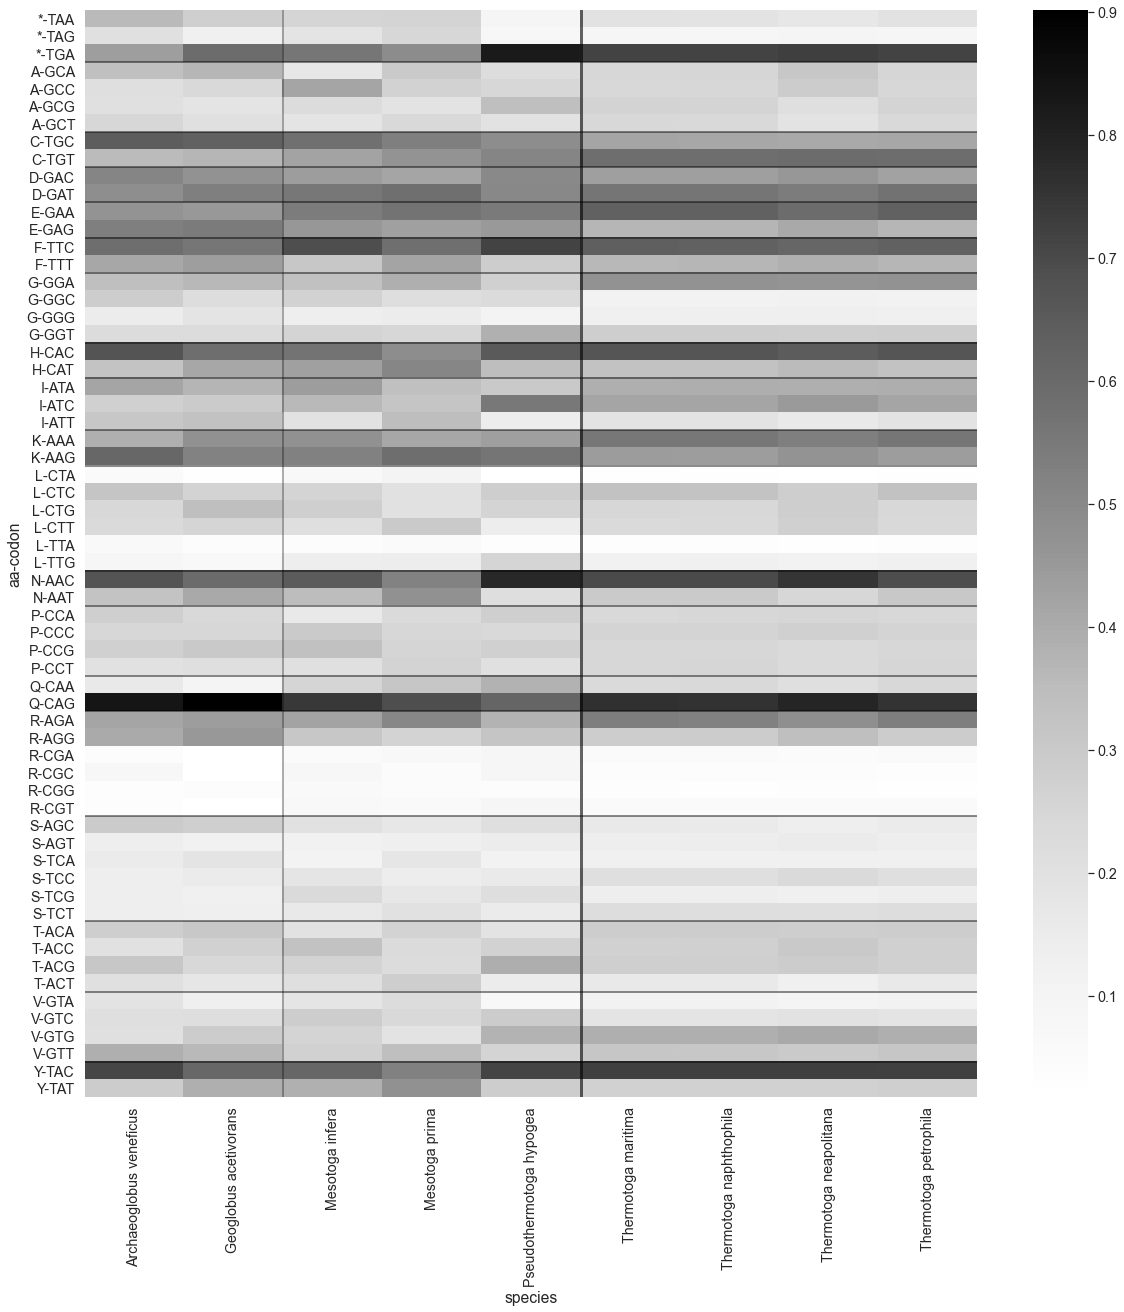

In [1237]:
ax, heatmap_df = make_heatmap(
    species_codon_df[
        species_codon_df['species_taxid'].isin(
            neighbour_df['species_taxid'].values.tolist() + [2336]
        )
    ], 
    ratio_columns, 
    grouping_column='species',
    temperature_range=(0, 120),
    figsize=(20, 20),
)

prev_aa = None
for i, (aa, codon) in enumerate(heatmap_df.index.tolist()):
    if prev_aa is not None and aa != prev_aa:
        ax.axhline(i, color='black', alpha=0.6);
        prev_aa = aa
    else:
        prev_aa = aa

species_to_phylum = {
    species: phylum
    for phylum, species in species_codon_df[['phylum', 'species']].values
}
vertical_lines_sep(ax, heatmap_df, species_to_phylum, color='black', alpha=0.4);

for i, species in enumerate(heatmap_df.columns):
    if species in bacteria_species:
        ax.axvline(i, color='black', alpha=0.6, linewidth=3);
        break

In [1244]:
def most_correlated_aa_from_neighbours(species_codon_df, distance_matrix, ratio_columns, species_taxid, max_distance):
    index = species_codon_df[species_codon_df['species_taxid'] == species_taxid].index
    if len(index) == 0:
        raise ValueError(f'No species foudn with id {species_taxid}')
        
    ix = index[0]
    
    other_ix = [
        i for i, v in enumerate(distance_matrix[ix])
        if i != ix and v <= max_distance
    ]
    
    all_measures = []
    aa_list = []
    for other_index in other_ix:
        measures = []
        seen_codons = set()
        for c in possible_codons:
            if c in seen_codons:
                continue

            redundant_codons = [cod for cod, _ in CODON_REDUNDANCY[c]]
            if len(redundant_codons) < 2:
                seen_codons.add(c)
                continue

            aa = codon_to_aa_table[c]
            aa_list.append(aa)

            p = np.zeros((len(redundant_codons),))
            q = np.zeros((len(redundant_codons),))
            for i, codon in enumerate(redundant_codons):
                seen_codons.add(codon)
                pi, qi = species_codon_df.loc[[ix, other_index]][f'{codon}_ratio'].values
                p[i] = pi
                q[i] = qi

            measures.append(
                jensen_shannon_divergence(p, q)
            )
        
        all_measures.append(measures)
        
    avg_mesures = np.mean(all_measures, axis=0)
    
    return sorted(
        [
            (aa_list[i], avg_mesures[i])
            for i in range(len(avg_mesures))
        ],
        key=lambda t: t[1],
    )

In [1249]:
most_correlated_aa_from_neighbours(
    species_codon_df, distance_matrix, ratio_columns, species_taxid=2336, max_distance=threshold_distance)

[('D', 0.0007799467269615005),
 ('F', 0.0014119098144310918),
 ('P', 0.002031620519664627),
 ('H', 0.003232505721602191),
 ('N', 0.0038635502388189246),
 ('T', 0.004283755361816068),
 ('Y', 0.0046610051719975995),
 ('Q', 0.004865255733207527),
 ('K', 0.004946778056355858),
 ('E', 0.004995800545674859),
 ('A', 0.00595359012879638),
 ('I', 0.006942230921520069),
 ('R', 0.008046217619625016),
 ('S', 0.008577632074862129),
 ('L', 0.00890728613602228),
 ('C', 0.009152544414049193),
 ('V', 0.010110287603388762),
 ('G', 0.01240817873146247),
 ('*', 0.01353179671946442)]

## Build graph of nearby species 

In [1197]:
def build_graph(species_codon_df, distance_matrix, max_distance):
    graph = nx.Graph()
    
    for ix in range(len(species_codon_df)):
        if (ix + 1) % 200 == 0:
            logger.info(f'{ix + 1} / {len(species_codon_df)}')
            
        species_series = species_codon_df.loc[ix]
        
        species_taxid = species_series['species_taxid']
        if species_taxid not in graph.nodes:
            add_node(graph, species_series)

        nearby_ix = [
            i for i, v in enumerate(distance_matrix[ix])
            if i != ix and v <= max_distance
        ]
        
        for other_ix in nearby_ix:
            other_species_series = species_codon_df.loc[other_ix]
            other_species_taxid = other_species_series['species_taxid']
            
            if graph.has_edge(species_taxid, other_species_taxid):
                continue
            
            if other_species_taxid not in graph.nodes:
                add_node(graph, other_species_series)
                
            graph.add_edge(species_taxid, other_species_taxid, weight=distance_matrix[ix, other_ix])

    return graph


def add_node(graph, species_series):
    attributes = {
        'species': species_series['species'],
        'growth_tmp': species_series['growth_tmp'],
        'genus': species_series['genus'], 
        'family': species_series['family'], 
        'order': species_series['order'],
        'class': species_series['class'], 
        'phylum': species_series['phylum'], 
        'superkingdom': species_series['superkingdom'],
    }
    graph.add_node(species_series['species_taxid'], **attributes)

In [1198]:
%%time
graph = build_graph(species_codon_df, distance_matrix, max_distance=threshold_distance)

2020-11-11 21:05:56,054 (INFO) 100 / 2680
2020-11-11 21:05:58,833 (INFO) 200 / 2680
2020-11-11 21:06:00,807 (INFO) 300 / 2680
2020-11-11 21:06:04,204 (INFO) 400 / 2680
2020-11-11 21:06:06,586 (INFO) 500 / 2680
2020-11-11 21:06:09,686 (INFO) 600 / 2680
2020-11-11 21:06:10,670 (INFO) 700 / 2680
2020-11-11 21:06:12,699 (INFO) 800 / 2680
2020-11-11 21:06:15,298 (INFO) 900 / 2680
2020-11-11 21:06:18,191 (INFO) 1000 / 2680
2020-11-11 21:06:20,433 (INFO) 1100 / 2680
2020-11-11 21:06:22,573 (INFO) 1200 / 2680
2020-11-11 21:06:25,129 (INFO) 1300 / 2680
2020-11-11 21:06:27,699 (INFO) 1400 / 2680
2020-11-11 21:06:29,994 (INFO) 1500 / 2680
2020-11-11 21:06:32,567 (INFO) 1600 / 2680
2020-11-11 21:06:34,589 (INFO) 1700 / 2680
2020-11-11 21:06:36,784 (INFO) 1800 / 2680
2020-11-11 21:06:38,961 (INFO) 1900 / 2680
2020-11-11 21:06:41,607 (INFO) 2000 / 2680
2020-11-11 21:06:43,870 (INFO) 2100 / 2680
2020-11-11 21:06:46,292 (INFO) 2200 / 2680
2020-11-11 21:06:48,587 (INFO) 2300 / 2680
2020-11-11 21:06:50,

CPU times: user 1min 2s, sys: 218 ms, total: 1min 3s
Wall time: 1min 3s


In [1207]:
nx.number_connected_components(graph)

16

In [1210]:
for component in nx.connected_components(graph):
    if len(component) == 2:
        print(component) 

{200, 824}
{45363, 53558}


In [1518]:
def predict_temperature_from_neighbours_with_different_phylum(species_taxid):
    current_node = graph.nodes[species_taxid]
    current_phylum = current_node['phylum']
    tmps = []
    for key in graph.neighbors(species_taxid):
        node = graph.nodes[key]
        if key != species_taxid and node['phylum'] != current_phylum:
            temp = node['growth_tmp']
            tmps.append(temp)
            
    if len(tmps) == 0:
        prediction = None
    else:
        prediction = np.mean(tmps)

    return current_node['growth_tmp'], prediction


def predict_temperature_from_neighbours(species_taxid):
    current_node = graph.nodes[species_taxid]
    tmps = []
    for key in graph.neighbors(species_taxid):
        node = graph.nodes[key]
        if key != species_taxid:
            temp = node['growth_tmp']
            tmps.append(temp)
            
    if len(tmps) == 0:
        prediction = None
    else:
        prediction = np.mean(tmps)

    return current_node['growth_tmp'], prediction


def compute_mae_from_neighbour_predictions(species_taxids, control_for_phylum=True):
    actuals = []
    predictions = []

    for i, species_taxid in enumerate(species_taxids):
        if control_for_phylum:
            actual, prediction = predict_temperature_from_neighbours_with_different_phylum(species_taxid)
        else:
            actual, prediction = predict_temperature_from_neighbours(species_taxid)
        
        if prediction is None:
            continue
        
        actuals.append(actual)
        predictions.append(prediction)
        
    return mae(np.mean(actuals), np.mean(predictions))

In [1519]:
predict_temperature_from_neighbours_with_different_phylum(2336)

(80.0, 78.725)

In [1520]:
predict_temperature_from_neighbours_with_different_phylum(120)

(30.0, 33.42583333333334)

In [1521]:
predict_temperature_from_neighbours_with_different_phylum(29405)

(31.0, 31.8156976744186)

In [1522]:
compute_mae_from_neighbour_predictions(species_codon_df['species_taxid'].values)

0.22799978735923787

In [1523]:
compute_mae_from_neighbour_predictions(species_codon_df['species_taxid'].values, control_for_phylum=False)

1.0273254520904018

In [1525]:
100 * (0.23 - 1.03) / 1.03

-77.66990291262135

## What genes are driving the overall codon bias? 

In [1342]:
def distance_to_species_ratios(species_codon_df, ratio_columns, species_taxid, assembly_accession):
    query = """
    select metadata_json, sequence from sequences
    where assembly_accession = ? and sequence_type = 'CDS'
    """
    df = pd.read_sql(query, engine, params=(assembly_accession,))
    
    coding_sequences = df['sequence'].values
    descriptions = df['metadata_json'].values
    
    p = species_codon_df[
        species_codon_df['species_taxid'] == species_taxid
    ].iloc[0][ratio_columns].values.astype(float)
    
    aa_indices = get_aa_indices()
    
    distances = []
    metadata = []
    for i, sequence in enumerate(coding_sequences):
        q = compute_codon_ratios(sequence, ratio_columns)
        dist = compute_distance_to_target(p, q, aa_indices)
        distances.append(dist)
        metadata.append(descriptions[i]) 
        
    return np.array(distances), np.array(metadata)


def compute_distance_to_target(x, y, aa_indices):
    distances = []
    for ix in aa_indices:
        p = x[ix]
        q = y[ix]
        
        d = jensen_shannon_divergence(p, q)
        
        distances.append(d)
        
    return np.mean(distances)

        
def compute_codon_ratios(sequence, ratio_columns):
    codon_count = collections.defaultdict(int)
    assert len(sequence) % 3 == 0
    for pos in range(0, len(sequence), 3):
        codon = sequence[pos:pos+3]
        if codon not in CODON_REDUNDANCY:
            # Ignore ambiguous letters (e.g. N, etc)
            continue

        codon_count[codon] += 1
        
    codon_ratios = np.zeros((62,))
    
    ordered_codons = [c.replace('_ratio', '') for c in ratio_columns]
    
    processed_codons = set()
    for codon in sorted(CODON_REDUNDANCY.keys()):
        if codon in processed_codons:
            continue
        elif len(CODON_REDUNDANCY[codon]) <= 1:
            processed_codons.add(codon)
            continue
        
        synonymous_codons = CODON_REDUNDANCY[codon]
        
        aa_sum = np.sum([codon_count[cod] for cod, _ in synonymous_codons])
        
        for i, (c, _) in enumerate(synonymous_codons):
            processed_codons.add(c)
            
            ix = ordered_codons.index(c)
            
            if aa_sum > 0:
                codon_ratios[ix] = codon_count[c] / aa_sum
            else:
                codon_ratios[ix] = 1 / len(synonymous_codons)
            
    return codon_ratios


def get_aa_indices():
    processed_codons = set()
    indices = []
    i = 0
    for codon in sorted(CODON_REDUNDANCY.keys()):
        if codon in processed_codons:
            continue

        elif len(CODON_REDUNDANCY[codon]) <= 1:
            processed_codons.add(codon)
            continue

        row = []
        synonymous_codons = CODON_REDUNDANCY[codon]
        for c, _ in synonymous_codons:
            processed_codons.add(c)
            row.append(i)
            i += 1

        indices.append(row)

    return indices

In [1351]:
pd.read_sql(
    'select assembly_accession from assembly_source where species_taxid = 565033',
    engine
)

,assembly_accession
0,GCA_000789255.1


In [1343]:
species_taxid = 2336
assembly_accession = 'GCA_000008545.1'
distances, metadata = distance_to_species_ratios(species_codon_df, ratio_columns, species_taxid, assembly_accession)

In [1359]:
def proteins_following_codon_bias(species_codon_df, ratio_columns, species_taxid, assembly_accession):
    distances, metadata = distance_to_species_ratios(
        species_codon_df, ratio_columns, species_taxid, assembly_accession)
    sort_ix = np.argsort(distances)
    thres = np.mean(distances) - 1.1 * np.std(distances)
    
    _, ax = plt.subplots(1, 1, figsize=(12, 6))
    ax.hist(distances, bins=50);
    ax.axvline(thres, color='red');
    
    return [json.loads(metadata[ix])['protein'] for ix in sort_ix if distances[ix] <= thres]

['DNA-directed RNA polymerase, beta subunit',
 'comE protein, putative',
 'alpha-mannosidase, putative',
 'conserved hypothetical protein',
 'alpha-mannosidase-related protein',
 'hypothetical protein',
 'conserved hypothetical protein',
 'hypothetical protein',
 'sensor histidine kinase',
 'conserved hypothetical protein',
 'iron(II) transport protein B',
 'DNA-directed DNA polymerase I',
 'conserved hypothetical protein',
 'DNA gyrase, subunit A',
 'cation-transporting ATPase, P-type',
 'lipopolysaccharide biosynthesis protein',
 '(R)-2-hydroxyglutaryl-CoA dehydratase activator-related protein',
 'oligopeptide ABC transporter, periplasmic oligopeptide-binding protein',
 'DNA mismatch repair protein',
 'conserved hypothetical protein',
 'pyrimidine-nucleoside phosphorylase',
 'pleD-related protein',
 'anthranilate synthase component II',
 'alpha-amylase',
 'conserved hypothetical protein',
 '5-methyltetrahydrofolate S-homocysteine methyltransferase',
 'beta-glucosidase',
 'beta-D-gala

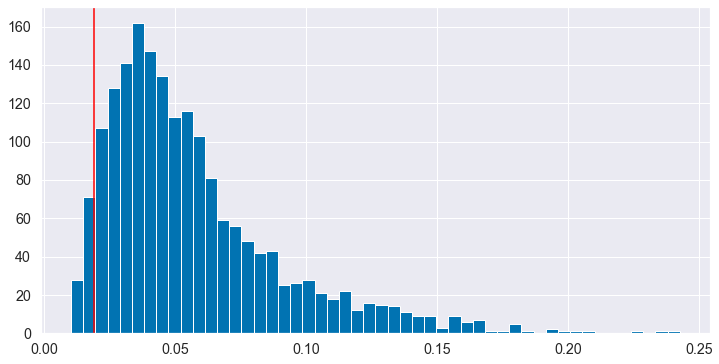

In [1360]:
proteins_following_codon_bias(
    species_codon_df, 
    ratio_columns, 
    species_taxid=2336, 
    assembly_accession='GCA_000008545.1',
)

['ATP-dependent helicase',
 'heterodisulfide reductase, subunit A',
 'Phosphoribosylformylglycinamidine synthase, synthetase subunit',
 'Long-chain-fatty-acid--CoA ligase',
 'chorismate mutase/prephenate dehydratase',
 'carboxypeptidase',
 'Protein similar to polyadenylation specificity factor',
 'Lead, cadmium, zinc and mercury transporting ATPase',
 'hypothetical protein',
 'Archaeal DNA polymerase I',
 'ATP-dependent helicase',
 'Long-chain-fatty-acid--CoA ligase',
 'CAP family transcription factor',
 'DNA recombination protein RmuC',
 'CO dehydrogenase/acetyl-CoA synthase corrinoid activation protein',
 'ATP-dependent RNA helicase, EIF-4A family',
 'hypothetical protein',
 'Radical SAM domain protein',
 'transglutaminase-like protein',
 'Cobyric acid synthase',
 "DNA-directed RNA polymerase subunit A'",
 'Cell division control protein 6 (cdc6)',
 'Phosphoribosylamine--glycine ligase',
 'hypothetical protein',
 'Radical SAM domain protein',
 'pyridine nucleotide-disulfide oxidoreduc

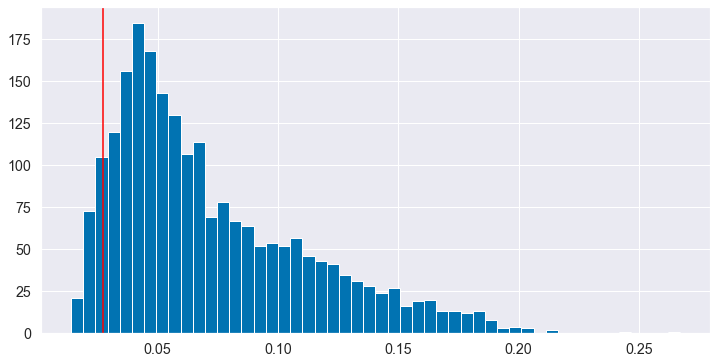

In [1361]:
proteins_following_codon_bias(
    species_codon_df, 
    ratio_columns, 
    species_taxid=565033, 
    assembly_accession='GCA_000789255.1',
)

## Most common protein within proteins following codon bias

In [1618]:
def protein_description_word_count(assembly_accession, below_threshold=True, count_type='document'):
    if count_type not in ('document', 'term'):
        raise ValueError('count type should be one of document or term')
        
    cds_codon_bias_folder = os.path.join(os.getcwd(), 'data/cds_codon_bias')
    if below_threshold:
        cds_codon_bias_folder = os.path.join(cds_codon_bias_folder, 'below_threshold')
    else:
        cds_codon_bias_folder = os.path.join(cds_codon_bias_folder, 'all')
        
    cds_codon_bias_path = os.path.join(cds_codon_bias_folder, f'{assembly_accession}_codon_bias.csv')
    
    black_list = [
        '',
        #'dna',
        #'rna',
        #'t-rna',
        #'trna',
        'protein',
        'enzyme',
        'subunit',
        'domain',
        'domain-containing',
        'hypothetical',
        'putative',
        'probable',
        'conserved',
        'factor',
        'large',
        'small',
        'family',
        'superfamily',
        'outer',
        'cell',
        'i',
        'ii',
        'iii',
        'iv',
        'v',
        'vi',
        'alpha',
        'beta',
        'gamma',
        'type',
        'and',
        'or',
        'of',
        'class',
        'assembly',
        'acid',
        'component',
        'response',
        '2x',
        '1-2',
    ]
    black_list += [c for c in string.ascii_lowercase]
    black_list += [c for c in string.digits]
    black_list = set(black_list)
    
    df = pd.read_csv(cds_codon_bias_path)
    descriptions = df['description'].values
    
    counts = collections.defaultdict(int)
    for description in descriptions:
        desc = str(description).replace(',', '').replace('.', '').replace('(', '').replace(')', '').strip()
        parts_1 = desc.split(' ')
        parts = []
        for p in parts_1:
            parts  += [v.lower() for v in p.split('/')]
            
        for word in parts:
            if word in black_list:
                continue
                
            if count_type == 'document':
                counts[word] = 1
            else:
                counts[word] += 1
    
    return dict(counts)


def compute_word_count(assembly_accessions, below_threshold=True, count_type='document', sorted_output=True):
    if count_type not in ('document', 'term'):
        raise ValueError('count type should be one of document or term')
    
    total_counts = {}
    for i, assembly_accession in enumerate(assembly_accessions):
        if (i+1) % 200 == 0:
            print(f'{i+1} / {len(assembly_accessions)}')
            
        counts = protein_description_word_count(assembly_accession, below_threshold, count_type)
        
        for k, v in counts.items():
            total_counts[k] = total_counts.get(k, 0) + counts[k]
    
    if sorted_output:
        word_counts = [
            (
                k, 
                np.round(100 * v / len(assembly_accessions), 2)
            ) 

            for k, v in total_counts.items()
        ]

        return sorted(word_counts, key=lambda t: t[1], reverse=True)
    else:
        return total_counts

In [1541]:
assembly_accessions = codon_frequency_df['assembly_accession'].values

In [1513]:
%%time
word_counts = compute_word_count(assembly_accessions)

200 / 3282
400 / 3282
600 / 3282
800 / 3282
1000 / 3282
1200 / 3282
1400 / 3282
1600 / 3282
1800 / 3282
2000 / 3282
2200 / 3282
2400 / 3282
2600 / 3282
2800 / 3282
3000 / 3282
3200 / 3282
CPU times: user 22.5 s, sys: 1.67 s, total: 24.1 s
Wall time: 24.2 s


In [1514]:
len(word_counts)

23178

In [1515]:
word_counts[:100]

[('synthase', 95.86),
 ('helicase', 92.14),
 ('kinase', 91.8),
 ('dehydrogenase', 90.07),
 ('polymerase', 88.79),
 ('transporter', 88.73),
 ('abc', 87.14),
 ('ligase', 86.72),
 ('atpase', 86.11),
 ('reductase', 85.89),
 ('synthetase', 85.5),
 ('atp-dependent', 85.47),
 ('oxidoreductase', 80.65),
 ('regulator', 74.83),
 ('atp-binding', 74.71),
 ('histidine', 74.53),
 ('hydrolase', 72.82),
 ('permease', 70.29),
 ('peptidase', 70.26),
 ('repair', 67.89),
 ('transcriptional', 66.76),
 ('system', 66.58),
 ('protease', 66.21),
 ('membrane', 64.2),
 ('oxidase', 64.14),
 ('biosynthesis', 63.86),
 ('sensor', 62.74),
 ('topoisomerase', 61.4),
 ('transferase', 59.99),
 ('aminotransferase', 59.78),
 ('serine', 58.96),
 ('excinuclease', 58.56),
 ('penicillin-binding', 57.1),
 ('mismatch', 54.24),
 ('carboxylase', 52.77),
 ('pyruvate', 52.71),
 ('dehydratase', 52.65),
 ('transport', 51.83),
 ('glycosyl', 49.76),
 ('decarboxylase', 49.39),
 ('glutamate', 49.12),
 ('methyltransferase', 49.06),
 ('bifu

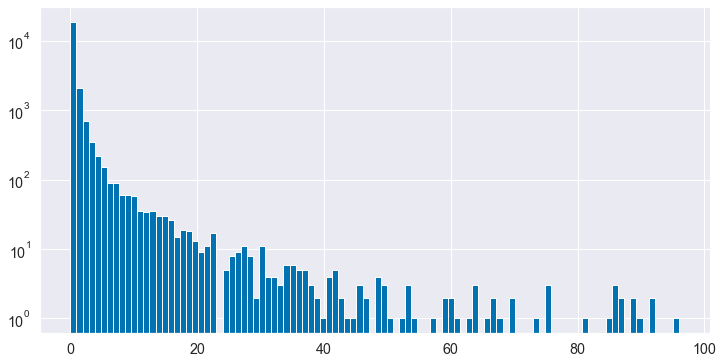

In [1516]:
_, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.hist([int(np.round(t[1], 0)) for t in word_counts], bins=100, log=True);

In [1537]:
%%time
word_counts = compute_word_count(assembly_accessions, below_threshold=False)

200 / 3282
400 / 3282
600 / 3282
800 / 3282
1000 / 3282
1200 / 3282
1400 / 3282
1600 / 3282
1800 / 3282
2000 / 3282
2200 / 3282
2400 / 3282
2600 / 3282
2800 / 3282
3000 / 3282
3200 / 3282
CPU times: user 2min 16s, sys: 14.9 s, total: 2min 31s
Wall time: 2min 35s


In [1538]:
word_counts[:100]

[('synthase', 99.88),
 ('kinase', 99.88),
 ('ribosomal', 99.88),
 ('atp', 99.76),
 ('methyltransferase', 99.7),
 ('polymerase', 99.7),
 ('dehydrogenase', 99.57),
 ('isomerase', 99.54),
 ('transporter', 99.51),
 ('phosphoribosyltransferase', 99.51),
 ('ribonuclease', 99.45),
 ('abc', 99.42),
 ('initiation', 99.42),
 ('elongation', 99.3),
 ('signal', 99.24),
 ('transcription', 99.21),
 ('deaminase', 99.21),
 ('translation', 99.18),
 ('helicase', 99.12),
 ('regulator', 99.12),
 ('reductase', 99.02),
 ('system', 98.96),
 ('atp-binding', 98.93),
 ('dna-binding', 98.93),
 ('hydrolase', 98.75),
 ('transcriptional', 98.69),
 ('chain', 98.6),
 ('atpase', 98.48),
 ('transferase', 98.42),
 ('synthetase', 98.32),
 ('adenylate', 98.29),
 ('serine', 98.23),
 ('rrna', 98.2),
 ('thioredoxin', 98.2),
 ('adenylyltransferase', 98.11),
 ('phosphate', 98.05),
 ('dna-directed', 98.02),
 ('acetyltransferase', 97.99),
 ('endonuclease', 97.99),
 ('biosynthesis', 97.9),
 ('peptide', 97.9),
 ('division', 97.87),

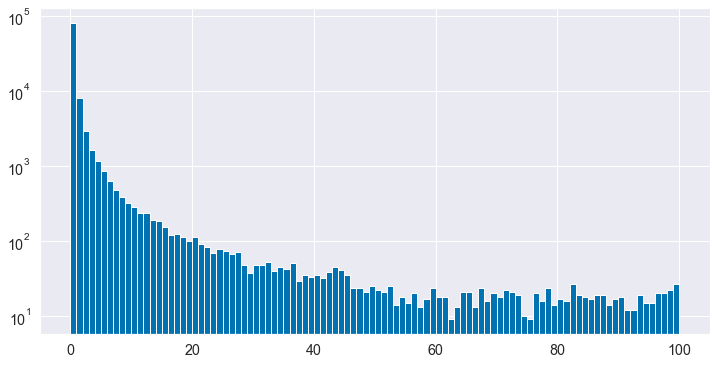

In [1539]:
_, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.hist([int(np.round(t[1], 0)) for t in word_counts], bins=100, log=True);

In [1682]:
def compute_word_scores(assembly_accessions):
    top_term_freq = compute_word_count(
        assembly_accessions,
        below_threshold=True,
        count_type='term',
        sorted_output=False,
    )
    all_term_freq = compute_word_count(
        assembly_accessions,
        below_threshold=False,
        count_type='term',
        sorted_output=False,
    )
    top_document_freq = compute_word_count(
        assembly_accessions,
        below_threshold=True,
        count_type='document',
        sorted_output=False,
    )
    all_document_freq = compute_word_count(
        assembly_accessions,
        below_threshold=False,
        count_type='document',
        sorted_output=False,
    )
    all_words = sorted(all_document_freq.keys())
    
    word_scores = []
    for word in all_words:
        term_freq = top_term_freq.get(word, 0)
        document_freq = top_document_freq.get(word, 0)
        
        if term_freq < 100:
            continue
        elif document_freq < 10:
            continue
            
        term_score = term_freq / all_term_freq[word]
        document_score = document_freq / all_document_freq[word]
        score = (term_score + document_score) / 2
        
        word_scores.append((
            word, score, term_score, document_score
        ))
        
    return (
        sorted(word_scores, key=lambda t: t[1], reverse=True), 
        top_term_freq, 
        all_term_freq,
        top_document_freq,
        all_document_freq,
    )

In [1683]:
%%time
(
    word_scores,
    top_term_freq, 
    all_term_freq,
    top_document_freq,
    all_document_freq,
) = compute_word_scores(assembly_accessions)
print(f'{len(word_scores):,}')

200 / 3282
400 / 3282
600 / 3282
800 / 3282
1000 / 3282
1200 / 3282
1400 / 3282
1600 / 3282
1800 / 3282
2000 / 3282
2200 / 3282
2400 / 3282
2600 / 3282
2800 / 3282
3000 / 3282
3200 / 3282
200 / 3282
400 / 3282
600 / 3282
800 / 3282
1000 / 3282
1200 / 3282
1400 / 3282
1600 / 3282
1800 / 3282
2000 / 3282
2200 / 3282
2400 / 3282
2600 / 3282
2800 / 3282
3000 / 3282
3200 / 3282
200 / 3282
400 / 3282
600 / 3282
800 / 3282
1000 / 3282
1200 / 3282
1400 / 3282
1600 / 3282
1800 / 3282
2000 / 3282
2200 / 3282
2400 / 3282
2600 / 3282
2800 / 3282
3000 / 3282
3200 / 3282
200 / 3282
400 / 3282
600 / 3282
800 / 3282
1000 / 3282
1200 / 3282
1400 / 3282
1600 / 3282
1800 / 3282
2000 / 3282
2200 / 3282
2400 / 3282
2600 / 3282
2800 / 3282
3000 / 3282
3200 / 3282
1,376
CPU times: user 5min 22s, sys: 32.3 s, total: 5min 55s
Wall time: 6min 3s


In [1688]:
word_scores_2 = sorted(word_scores, key=lambda t: t[1], reverse=True)

In [1689]:
[
    (t[0], np.round(100 * (t[2] * t[3]), 2), np.round(t[1], 2), np.round(t[2], 2), np.round(t[3], 2))
    for t in word_scores_2
    if t[1] >= 0.5
]

[('helicase-exonuclease', 80.69, 0.9, 0.88, 0.92),
 ('addab', 78.78, 0.89, 0.86, 0.91),
 ('adda', 70.19, 0.84, 0.84, 0.84),
 ('dnae', 65.57, 0.81, 0.8, 0.82),
 ('addb', 63.92, 0.8, 0.8, 0.8),
 ('spra', 61.17, 0.78, 0.78, 0.79),
 ('modules', 53.96, 0.74, 0.64, 0.84),
 ('polc', 54.84, 0.74, 0.71, 0.77),
 ('non-ribosomal', 54.3, 0.74, 0.69, 0.78),
 ('adenylation', 52.51, 0.73, 0.68, 0.77),
 ('duf490', 48.95, 0.7, 0.69, 0.71),
 ('alpha-2-macroglobulin', 46.74, 0.68, 0.67, 0.7),
 ('cobn', 46.35, 0.68, 0.66, 0.71),
 ('lhr', 45.14, 0.67, 0.65, 0.69),
 ('transcription-repair', 43.19, 0.66, 0.65, 0.66),
 ('transcription-repair-coupling', 41.6, 0.65, 0.63, 0.66),
 ('ca2+-transporting', 40.96, 0.64, 0.62, 0.66),
 ('polc-type', 40.14, 0.64, 0.58, 0.69),
 ('hrpa', 40.15, 0.63, 0.61, 0.66),
 ('alpha-mannosidase', 38.35, 0.62, 0.55, 0.7),
 ('nonribosomal', 38.69, 0.62, 0.62, 0.63),
 ('helicase', 26.48, 0.62, 0.28, 0.95),
 ('coupling', 37.48, 0.61, 0.57, 0.65),
 ('s-box-containing', 30.21, 0.6, 0.35, 

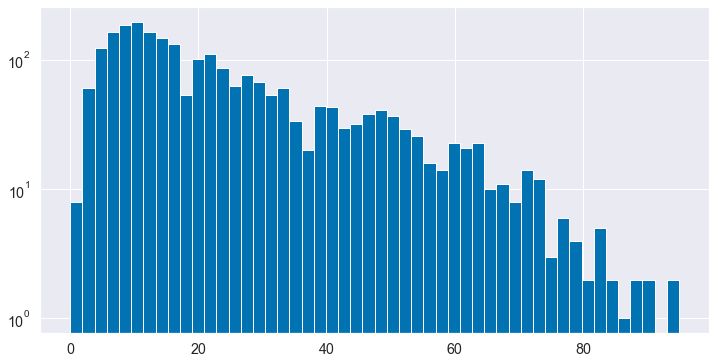

In [1676]:
_, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.hist([int(np.round(100 * t[2], 0)) for t in word_scores_2], bins=50, log=True);

In [1642]:
top_term_freq = compute_word_count(
    assembly_accessions,
    below_threshold=True,
    count_type='term',
    sorted_output=False,
)
top_document_freq = compute_word_count(
    assembly_accessions,
    below_threshold=True,
    count_type='document',
    sorted_output=False,
)

200 / 3282
400 / 3282
600 / 3282
800 / 3282
1000 / 3282
1200 / 3282
1400 / 3282
1600 / 3282
1800 / 3282
2000 / 3282
2200 / 3282
2400 / 3282
2600 / 3282
2800 / 3282
3000 / 3282
3200 / 3282
200 / 3282
400 / 3282
600 / 3282
800 / 3282
1000 / 3282
1200 / 3282
1400 / 3282
1600 / 3282
1800 / 3282
2000 / 3282
2200 / 3282
2400 / 3282
2600 / 3282
2800 / 3282
3000 / 3282
3200 / 3282


In [1643]:
top_term_freq_sorted = sorted(list(top_term_freq.items()), key=lambda t: t[1], reverse=True)
top_document_freq_sorted = sorted(list(top_document_freq.items()), key=lambda t: t[1], reverse=True)

In [1644]:
len([t[1] for t in top_term_freq_sorted if t[1] >= 20])

6172

In [1645]:
len([t[1] for t in top_document_freq_sorted if t[1] > 10])

7767

## Retrieve most common initial protein name

In [1692]:
def retrieve_most_common_protein_from_words(assembly_accessions, words):
    cds_codon_bias_folder = os.path.join(os.getcwd(), 'data/cds_codon_bias/below_threshold')

    counts = {}
    for ix, assembly_accession in enumerate(assembly_accessions):
        if (ix + 1) % 200 == 0:
            print(f'{ix + 1} / {len(assembly_accessions)}')
        
        cds_codon_bias_path = os.path.join(cds_codon_bias_folder, f'{assembly_accession}_codon_bias.csv')

        df = pd.read_csv(cds_codon_bias_path)
        descriptions = df['description'].values

        for description in descriptions:
            protein = str(description)
            desc = str(description).replace(',', '').replace('.', '').replace('(', '').replace(')', '').strip()
            parts_1 = desc.split(' ')
            parts = []
            for p in parts_1:
                parts  += [v.lower() for v in p.split('/')]
                
            parts_set = set(parts)

            for word in words:
                if word not in parts_set:
                    continue

                if word not in counts:
                    counts[word] = {}
                    
                if protein not in counts[word]:
                    counts[word][protein] = 1
                else:
                    counts[word][protein] += 1
                
    word_to_most_common_protein = {}
    for word in words:
        if word not in counts:
            continue
        
        l = sorted([(k, v) for k, v in counts[word].items()], key=lambda t: t[1])
        word_to_most_common_protein[word] = l[-1][0]
    
    return word_to_most_common_protein

In [1697]:
most_common_words = [t[0] for t in word_scores_2 if t[1] >= 0.5]

In [1693]:
%%time
word_to_most_common_protein = retrieve_most_common_protein_from_words(
    assembly_accessions, 
    most_common_words,
)

200 / 3282
400 / 3282
600 / 3282
800 / 3282
1000 / 3282
1200 / 3282
1400 / 3282
1600 / 3282
1800 / 3282
2000 / 3282
2200 / 3282
2400 / 3282
2600 / 3282
2800 / 3282
3000 / 3282
3200 / 3282
CPU times: user 27.1 s, sys: 2.16 s, total: 29.2 s
Wall time: 30.8 s


In [1694]:
word_to_most_common_protein['helicase']

'DEAD/DEAH box helicase'

In [1700]:
def compute_most_common_word_output(
    most_common_words, 
    word_to_most_common_protein,
    top_term_freq, 
    all_term_freq,
    top_document_freq,
    all_document_freq,
):
    columns = [
        'Keyword',
        'Most common protein',
        'Frequency',
        'Frequency in top',
        'Presence count',
        'Present count in top',
        'Term frequency score',
        'Presence score',
        'Score',
    ]
    data = []
    for word in most_common_words:
        term_score = top_term_freq[word] / all_term_freq[word]
        presence_score = top_document_freq[word] / all_document_freq[word]
        score = (term_score + presence_score) / 2
        data.append([
            word,
            word_to_most_common_protein[word],
            all_term_freq[word],
            top_term_freq[word],
            all_document_freq[word],
            top_document_freq[word],
            np.round(term_score, 2),
            np.round(presence_score, 2),
            np.round(score, 2),
        ])
    
    return pd.DataFrame(data, columns=columns)

In [1704]:
most_common_word_output = compute_most_common_word_output(
    most_common_words, 
    word_to_most_common_protein,
    top_term_freq, 
    all_term_freq,
    top_document_freq,
    all_document_freq,
)
most_common_word_output.head(20)

,Keyword,Most common protein,Frequency,Frequency in top,Presence count,Present count in top,Term frequency score,Presence score,Score
0,helicase-exonuclease,helicase-exonuclease AddAB subunit AddA,506,445,303,278,0.88,0.92,0.90
1,addab,helicase-exonuclease AddAB subunit AddA,519,448,309,282,0.86,0.91,0.89
2,adda,helicase-exonuclease AddAB subunit AddA,466,390,465,390,0.84,0.84,0.84
3,dnae,DNA polymerase III DnaE,130,104,122,100,0.80,0.82,0.81
4,addb,helicase-exonuclease AddAB subunit AddB,394,315,394,315,0.80,0.80,0.80
5,spra,cell surface protein SprA,169,131,166,131,0.78,0.79,0.78
6,modules,"Erythronolide synthase, modules 3 and 4",175,112,51,43,0.64,0.84,0.74
7,polc,DNA polymerase III PolC,262,186,233,180,0.71,0.77,0.74
8,non-ribosomal,non-ribosomal peptide synthetase,2267,1569,543,426,0.69,0.78,0.74
9,adenylation,amino acid adenylation domain-containing protein,1889,1285,513,396,0.68,0.77,0.73


In [1707]:
most_common_word_output.to_excel(
    os.path.join(os.getcwd(), 'data/codon_bias_common_proteins.xlsx'), 
    index=False,
)